# 01 HTTP trafiic estimator - student

# 1. Background

Hypothetical web start-up sells the service of providing machine learning algorithms via HTTP. With increasing success of the company, the demand for better infrastructure increases to serve all incoming web requests successfully. Company don't want to allocate too many resources as that would be too costly. On the other side, it will lose money, if company have not reserved enough resources to serve all incoming requests. 

The question is, `when will the company hit the limit of current infrastructure`, which is estimated to be at `100,000 requests per hour`. Company would like to know in advance when it have to request additional servers in the cloud to serve all the incoming requests successfully without paying for unused ones.

# 2. Reading the data

Company IT department have collected the web stats for the last month and aggregated them in `data/web_traffic.tsv` (.tsv because it contains tab-separated values). They are stored as the number of hits per hour. Each line contains the hour consecutively and the number of web hits in that hour.

In [9]:
# first check that the datafile exists
!powershell -Command "Get-Content ./web_traffic.tsv | Select-Object -First 4"

1.000000	2273.331055
2.000000	1657.255493
3.000000	nan
4.000000	1366.846436


In [11]:
# import libs needed and define constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot style



In [13]:
# read the data using pandas
# ToDo: read the dataset to variable named data
data = pd.read_csv('web_traffic.tsv', sep='\t', header=None)
# TODO: Check the shape of data
data.shape

(743, 2)

# 3. Preprocessing and cleaning the data

First get to know the data and then do the preprocessing.


In [23]:
# TODO: get an overview of the data
print(data.describe())
print(data.info())

                0            1
count  743.000000   735.000000
mean   372.000000  1965.282158
std    214.629914   860.844586
min      1.000000   473.342102
25%    186.500000  1390.618225
50%    372.000000  1769.132324
75%    557.500000  2224.593628
max    743.000000  5906.814941
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       743 non-null    float64
 1   1       735 non-null    float64
dtypes: float64(2)
memory usage: 11.7 KB
None


In [25]:
# ToDo: separate x (hours) and y (web requests per hour) values. use variables x and y
x = data[:][0]
y = data[:][1]
# TODO: modify the dataset item at x[0] (should be 1)
# x[0] = 1.0

In [27]:
# ToDo: check the number of nans
print(f'Nbr of NaNs: {np.sum(np.isnan(y))}')

Nbr of NaNs: 8


## 3.1. Handing the missing values

Nans can be handled on different ways. Here the data contains 8 nans:
- If number of nans are low, it is safe to just remove the rows. 
- Nans can be also replaced with mean, median or some other estimate
  - in this case it might be a good idea to just use average of pervious and next sample(s)
 
> Here remove the nans from the dataset using logical ~-operator.

In [33]:
# ToDo: remove nans using e.g. boolean array
x = x[~np.isnan(y)]
y = y[~np.isnan(y)]
print(f'Dataset shape is now: {x.shape} {y.shape}')

Dataset shape is now: (735,) (735,)


## 3.2. Plot the dataset 

Plot the dataset to get some sort of understanding and impression about the data.

> More tutorials on plotting can be found at [here](http://matplotlib.org/users/pyplot_tutorial.html)

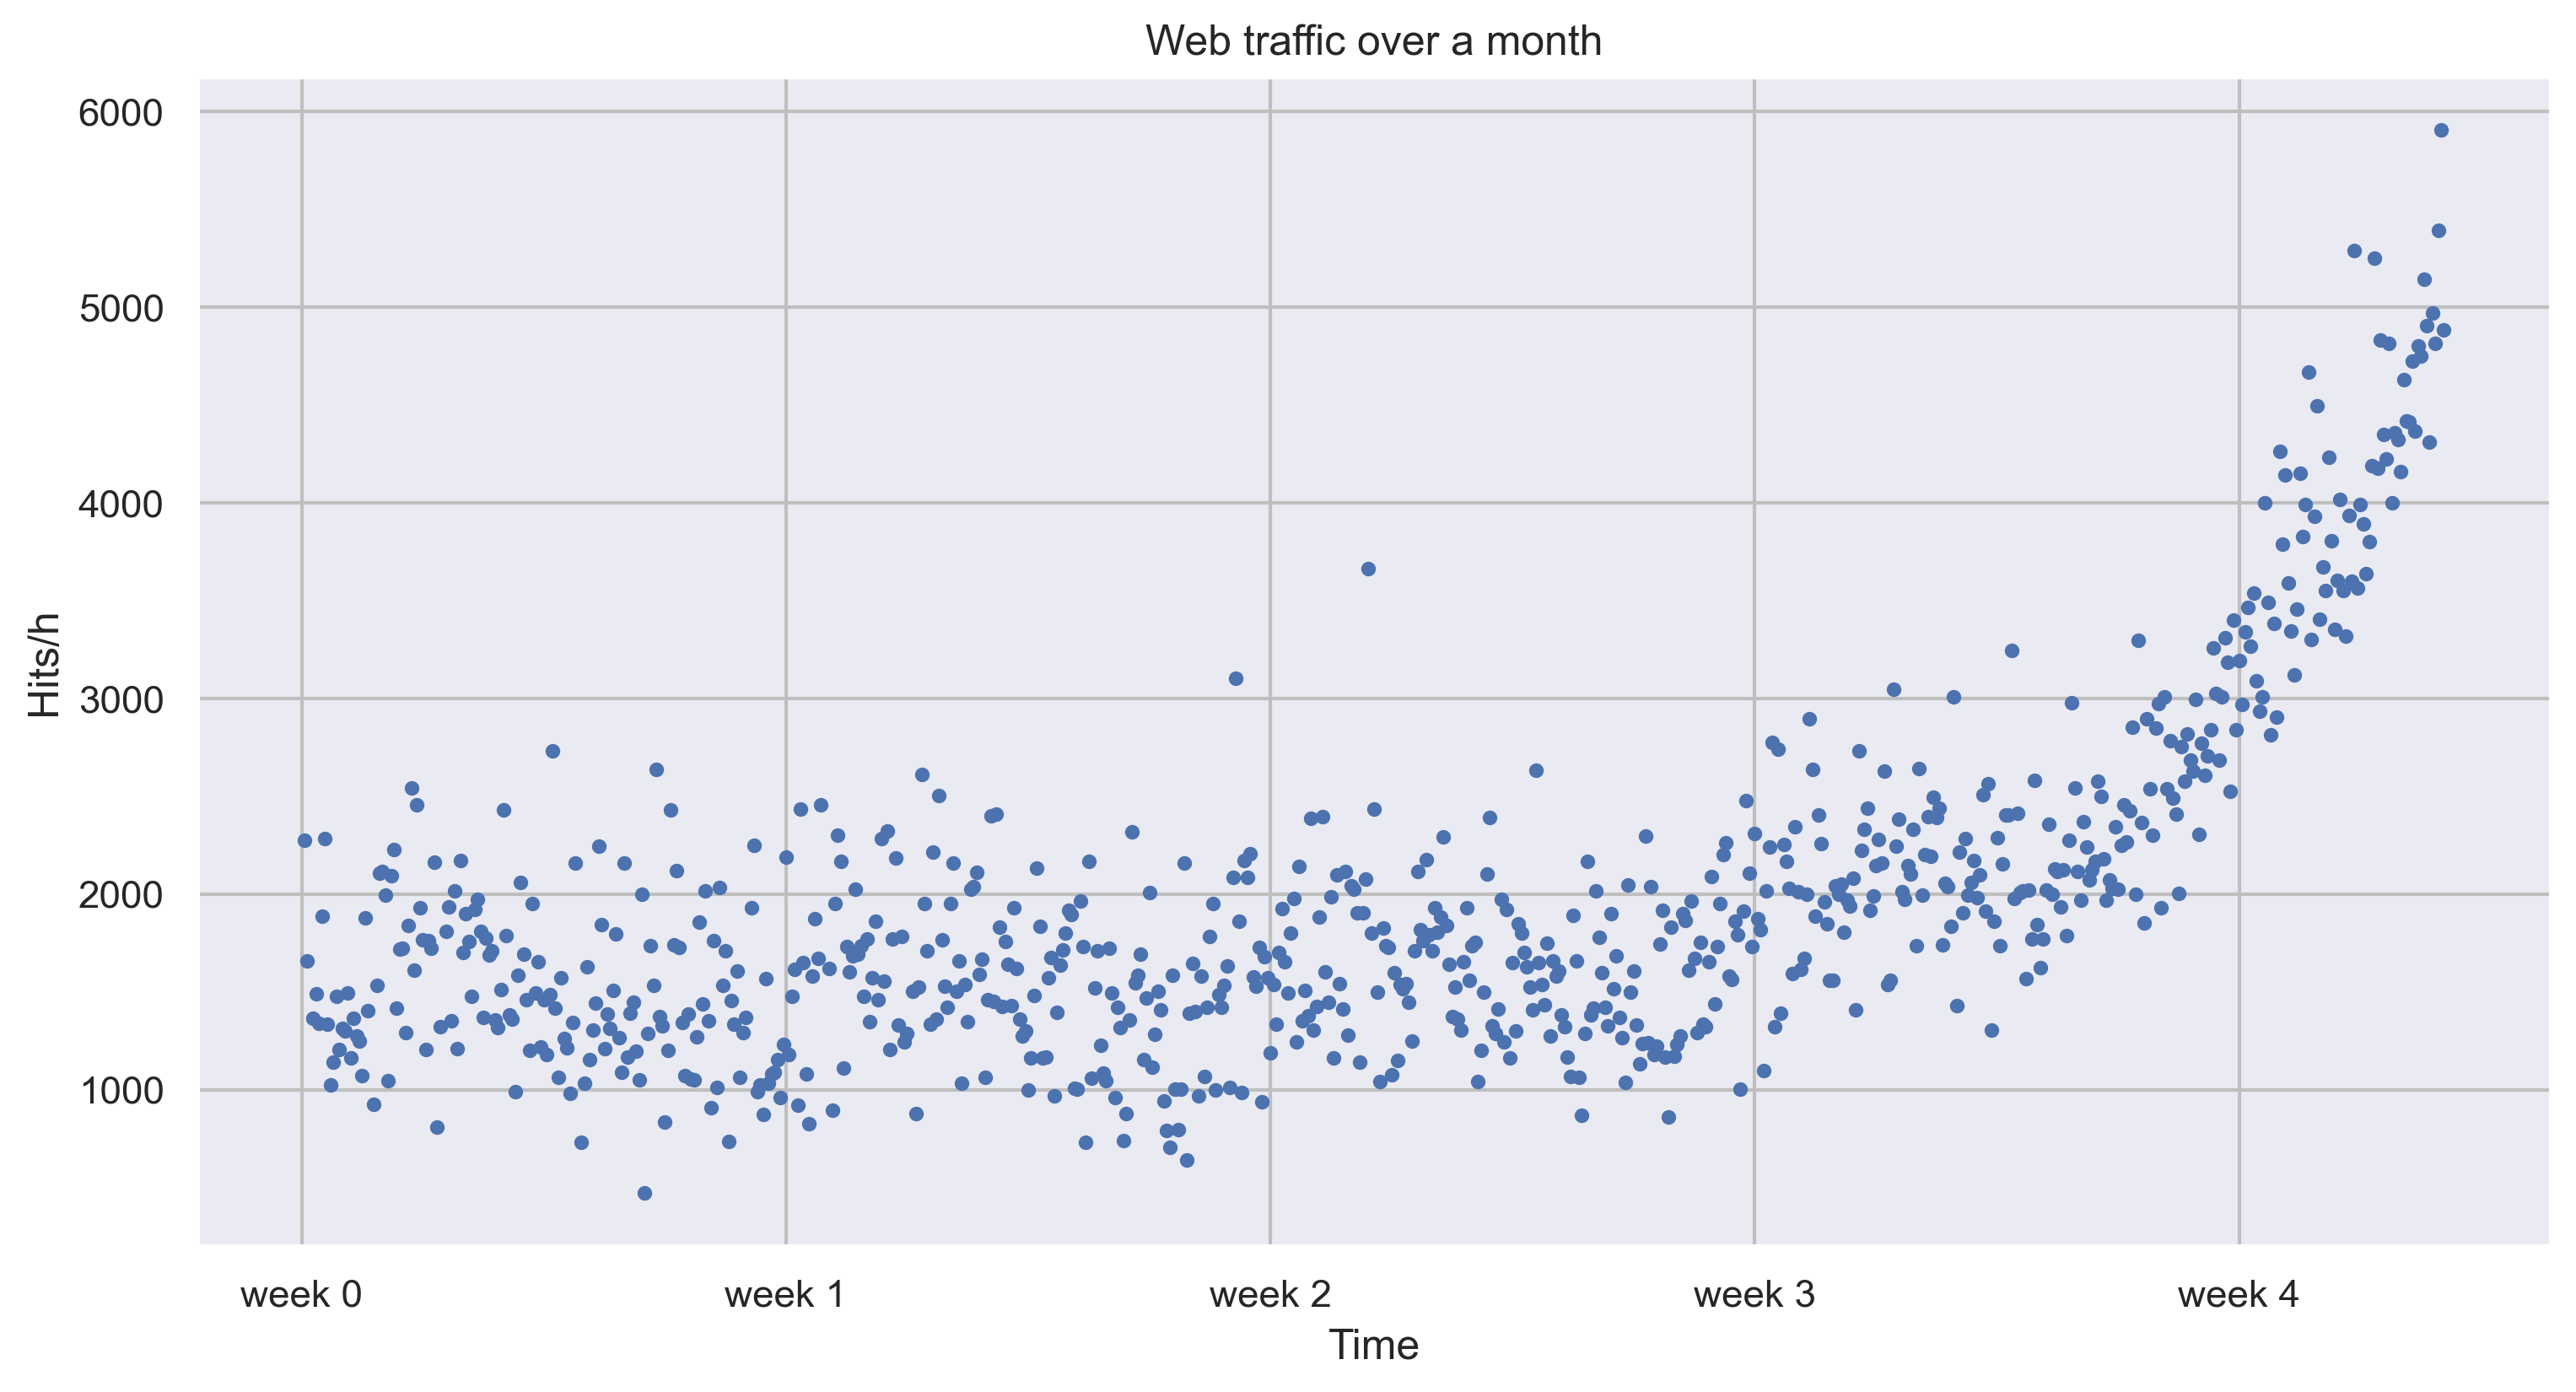

In [37]:
# plot just samples
plt.figure(figsize=(12, 6), dpi=300)

# ToDo: Create scatter plot from x vs y 
plt.scatter(x, y, s=10)
plt.title('Web traffic over a month')
plt.xlabel('Time')
plt.ylabel('Hits/h')
# TODO: Plot xticks (one per week)
plt.xticks([w*7*24 for w in range(5)], [f'week {w}' for w in range(5)])
# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

Plot analysis: while in the first weeks the traffic stayed more or less the same, the last week shows a steep increase.

## 4. Choosing the right model and learning algorithm

Now that a first impression of the data is seen, one can return to the initial question:  
How long will the server handle the incoming web traffic? 

To answer this one have to do the following:
1. Find the real model behind the noisy data points.
2. Following this, use the model to extrapolate into the future to find  the point in time where the infrastructure `has to be extended`.

### 4.1 Before building our first model...

When talk about models, one can think of them as simplified theoretical approximations of complex reality. As such there is always some inferiority involved, also called the approximation error. This error will guide us in choosing the right model among the myriad of choices we have. And this error will be calculated as the `squared distance` of the model's prediction to the real data; 

for example, for a learned model function f, the error is calculated as follows:

```python
def error(f, x, y):
    return sp.sum((f(x)-y)**2)
```

The vectors x and y contain the web stats data that IT department have extracted earlier.  

The trained model is assumed to take a vector and return the results again as a vector of the same size so that one can use it to calculate the difference to y.

### 4.2 Starting with a simple straight line

Let's assume for a second that the underlying model is a straight line. Then the challenge is how to best put that line into the chart so that it results in the smallest approximation error. Numpy polyfit() function does exactly that. Given data x and y and the desired order of the polynomial (a straight line has order 1), it finds the model function 
that minimizes the error function defined earlier:

```python
p, [residuals, rank, singular_values, rcond] = polynomial.polynomial.polyfit(x, y, deg, rcond=None, full=False, w=None)
```

Polyfit function fits a polynomial 

$p(x)=p[0]*x^{deg}+..+p[deg-1]*x^1+p[deg]$ 

of degree deg to points $(x, y)$. Returns a vector of coefficients p that minimises the squared error in the order deg, deg-1, … 0. 

And by setting full=True, we also get additional background information on the fitting process. Of this, only residuals are of interest, which is exactly the error of the approximation:


In [39]:
# define a error function Residual squared (=(estimate - actual)^2)
def error(f, x, y):
    return np.sum((f(x)-y)**2)

In [41]:
from numpy.polynomial import polynomial as P

# ToDo: learn the polyfit operation
p, [residuals, rank, singular_values, rcond] = P.polyfit(x, y, 1, full=True)
print("Model parameters: {} \nresiduals {}".format(p, residuals))

Model parameters: [996.50674246   2.58462016] 
residuals [3.19531507e+08]



This means the best straight line fit is the following function $f(x)=p[1]*x+p[0]$

In [43]:
# ToDo: learn the poly1d operation and print the model 
f1 = np.poly1d(p[::-1])
f1_residual = error(f1,x,y)
print('error: {:.10}'.format(f1_residual))
print(f1)

error: 319531507.0
 
2.585 x + 996.5


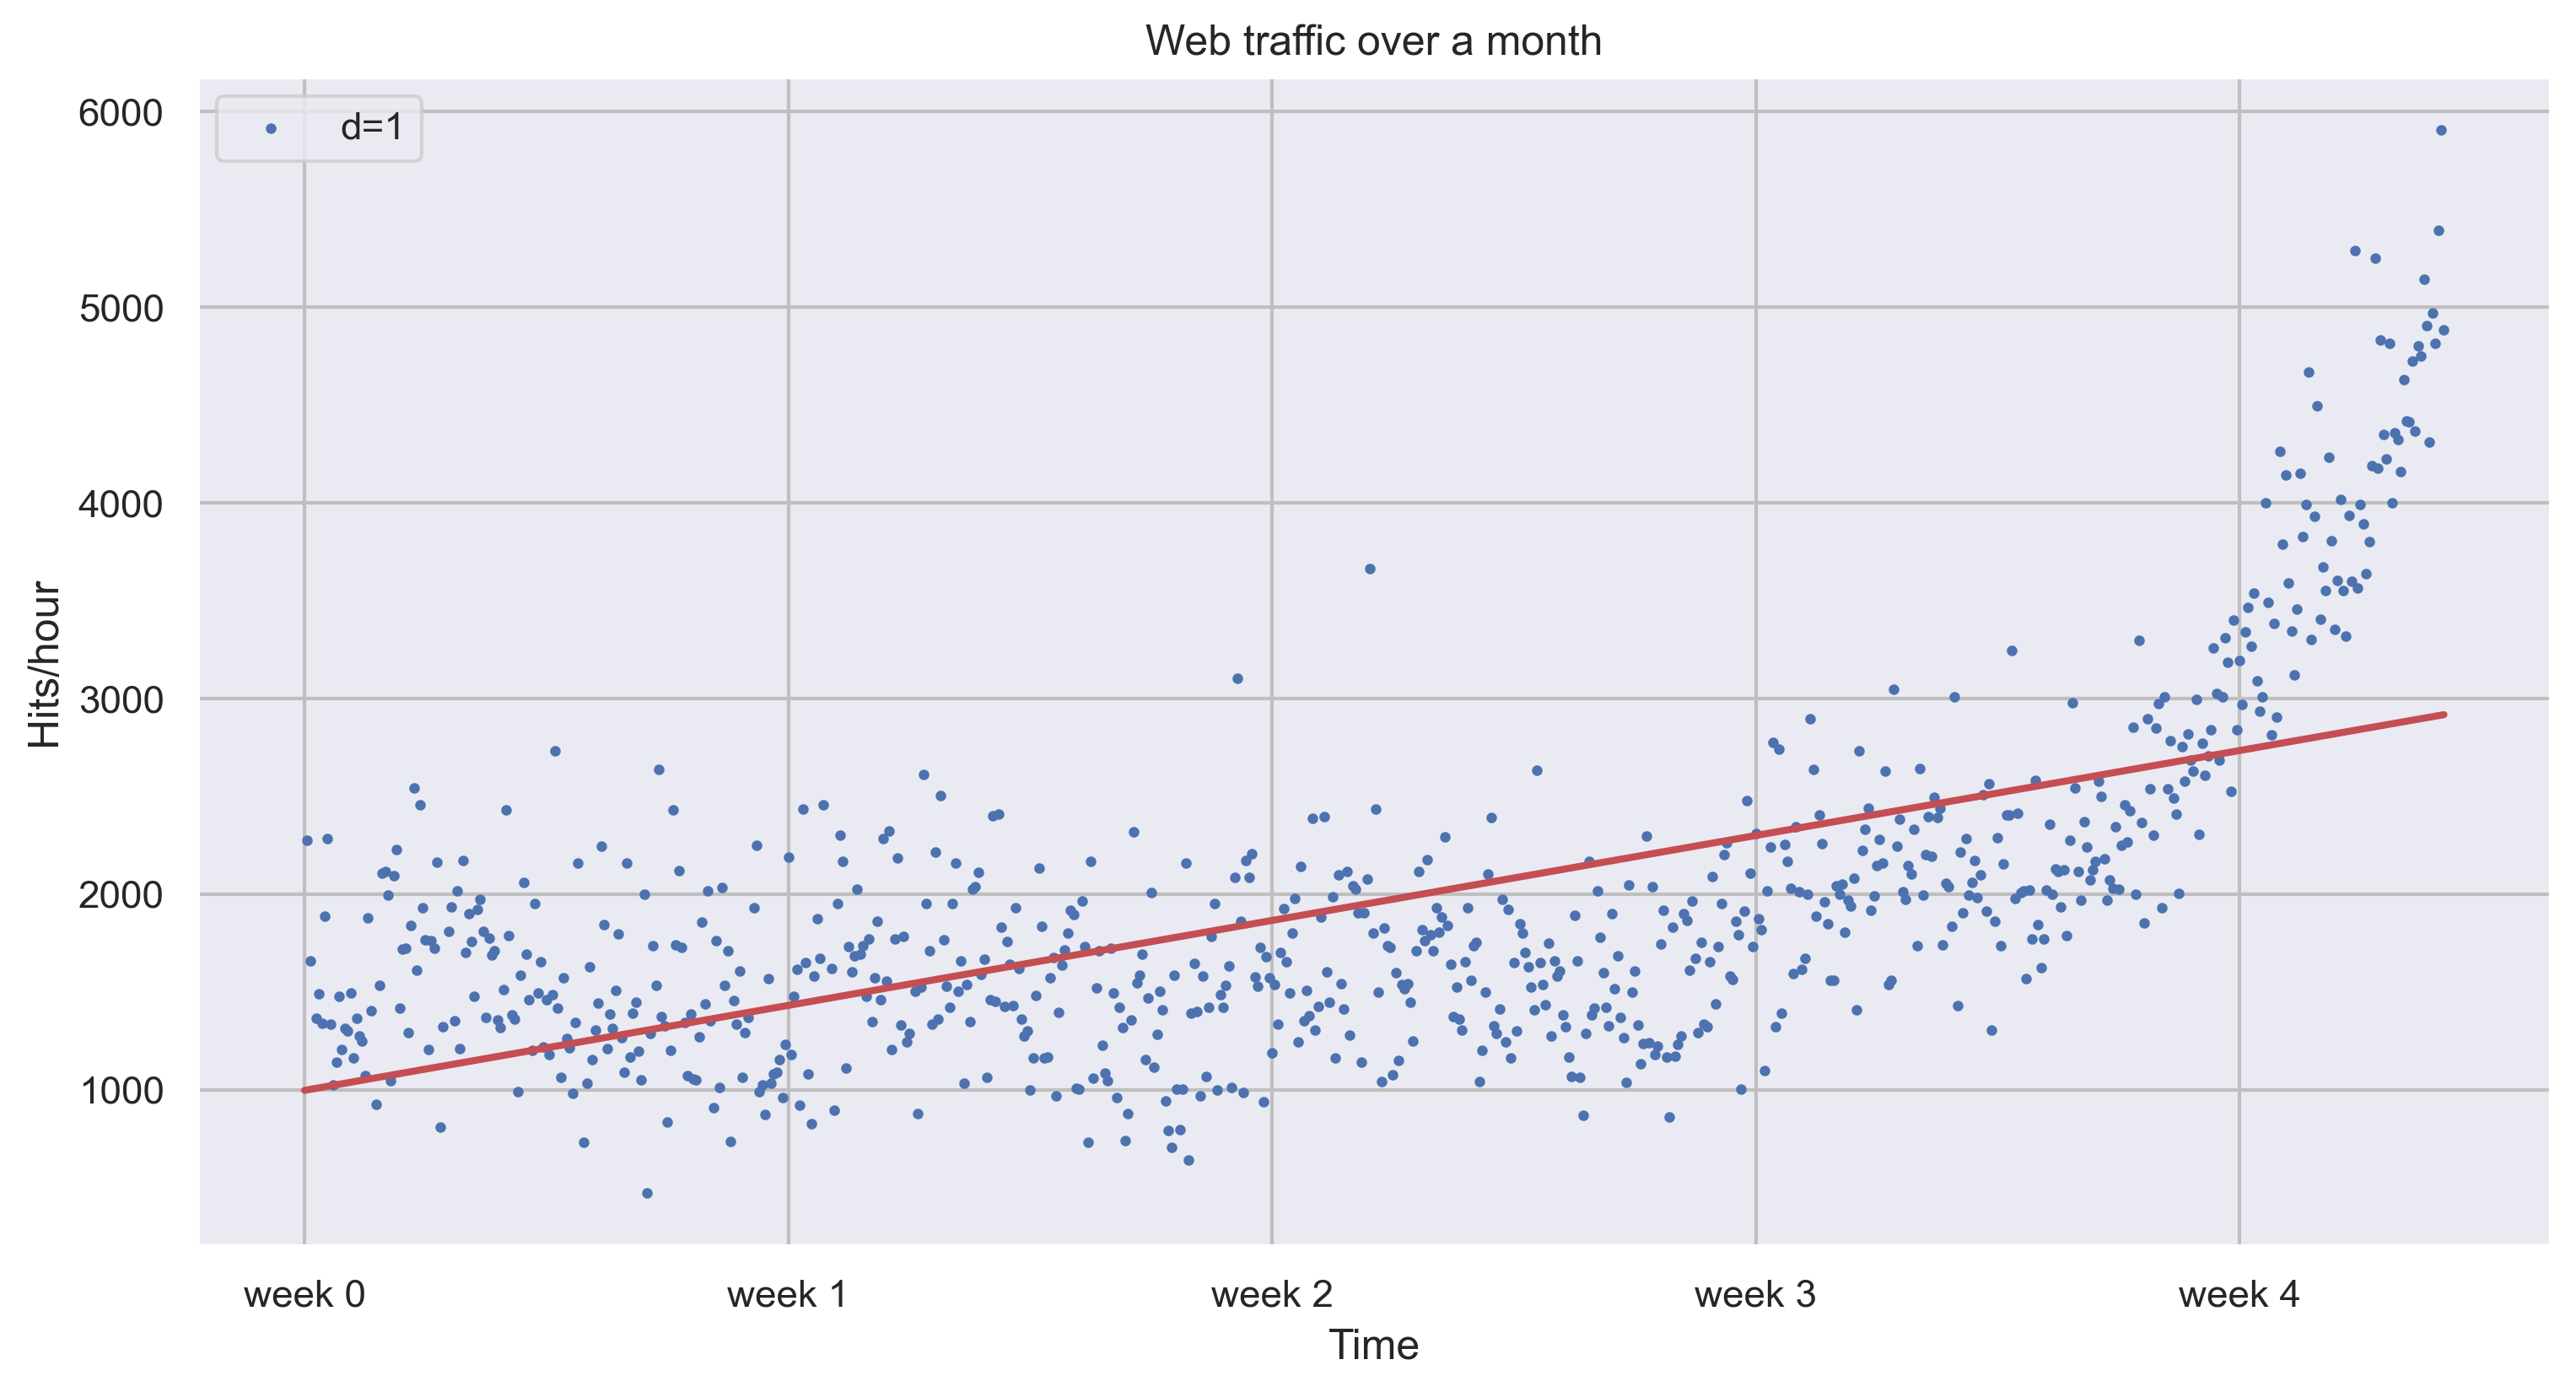

In [45]:
# Plot samples and regression line
fx = np.linspace(0,x.iloc[-1], 1000) # generate X-values for plotting 

plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=4)
plt.title("Web traffic over a month") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(5)],['week {}'.format(w) for w in range(5)])

# ToDo: plot the linear regression line
plt.plot(fx, f1(fx), 'r', linewidth=2)
plt.legend(["d={}".format(f1.order)], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

It seems like the first 4 weeks are not that far off, although we clearly see that there is something wrong with our initial assumption that the underlying model is a straight line. 

And then, how good or how bad actually is the error of 319 402 381.4.

The `absolute value of the error` is seldom of use in isolation. However, when comparing two competing models, we can use their errors to judge which one of them is better. Although the first model clearly is not the one company would use, it serves a very important purpose in the workflow. We will use it as a baseline until we find a better one. Whatever model we come up with in the future, we will compare it against the current baseline.

### 4.3 Towards some advanced stuff

Let's now fit a more complex model, a polynomial of degree 2, to see whether it better understands our data:

In [47]:
p2, [residuals, rank, singular_values, rcond] = P.polyfit(x, y, 2, full=True)
print("Model parameters: {} \nresiduals {}".format(p2, residuals))

Model parameters: [ 1.98466917e+03 -5.29774287e+00  1.05605675e-02] 
residuals [1.81347661e+08]


In [49]:
f2 = np.poly1d(p2[::-1])
f2_residual = error(f2,x,y)
print(f2)
print('error: {:.11} decreased by {:.2}'.format(error(f2,x,y), f2_residual/f1_residual))

         2
0.01056 x - 5.298 x + 1985
error: 181347660.76 decreased by 0.57


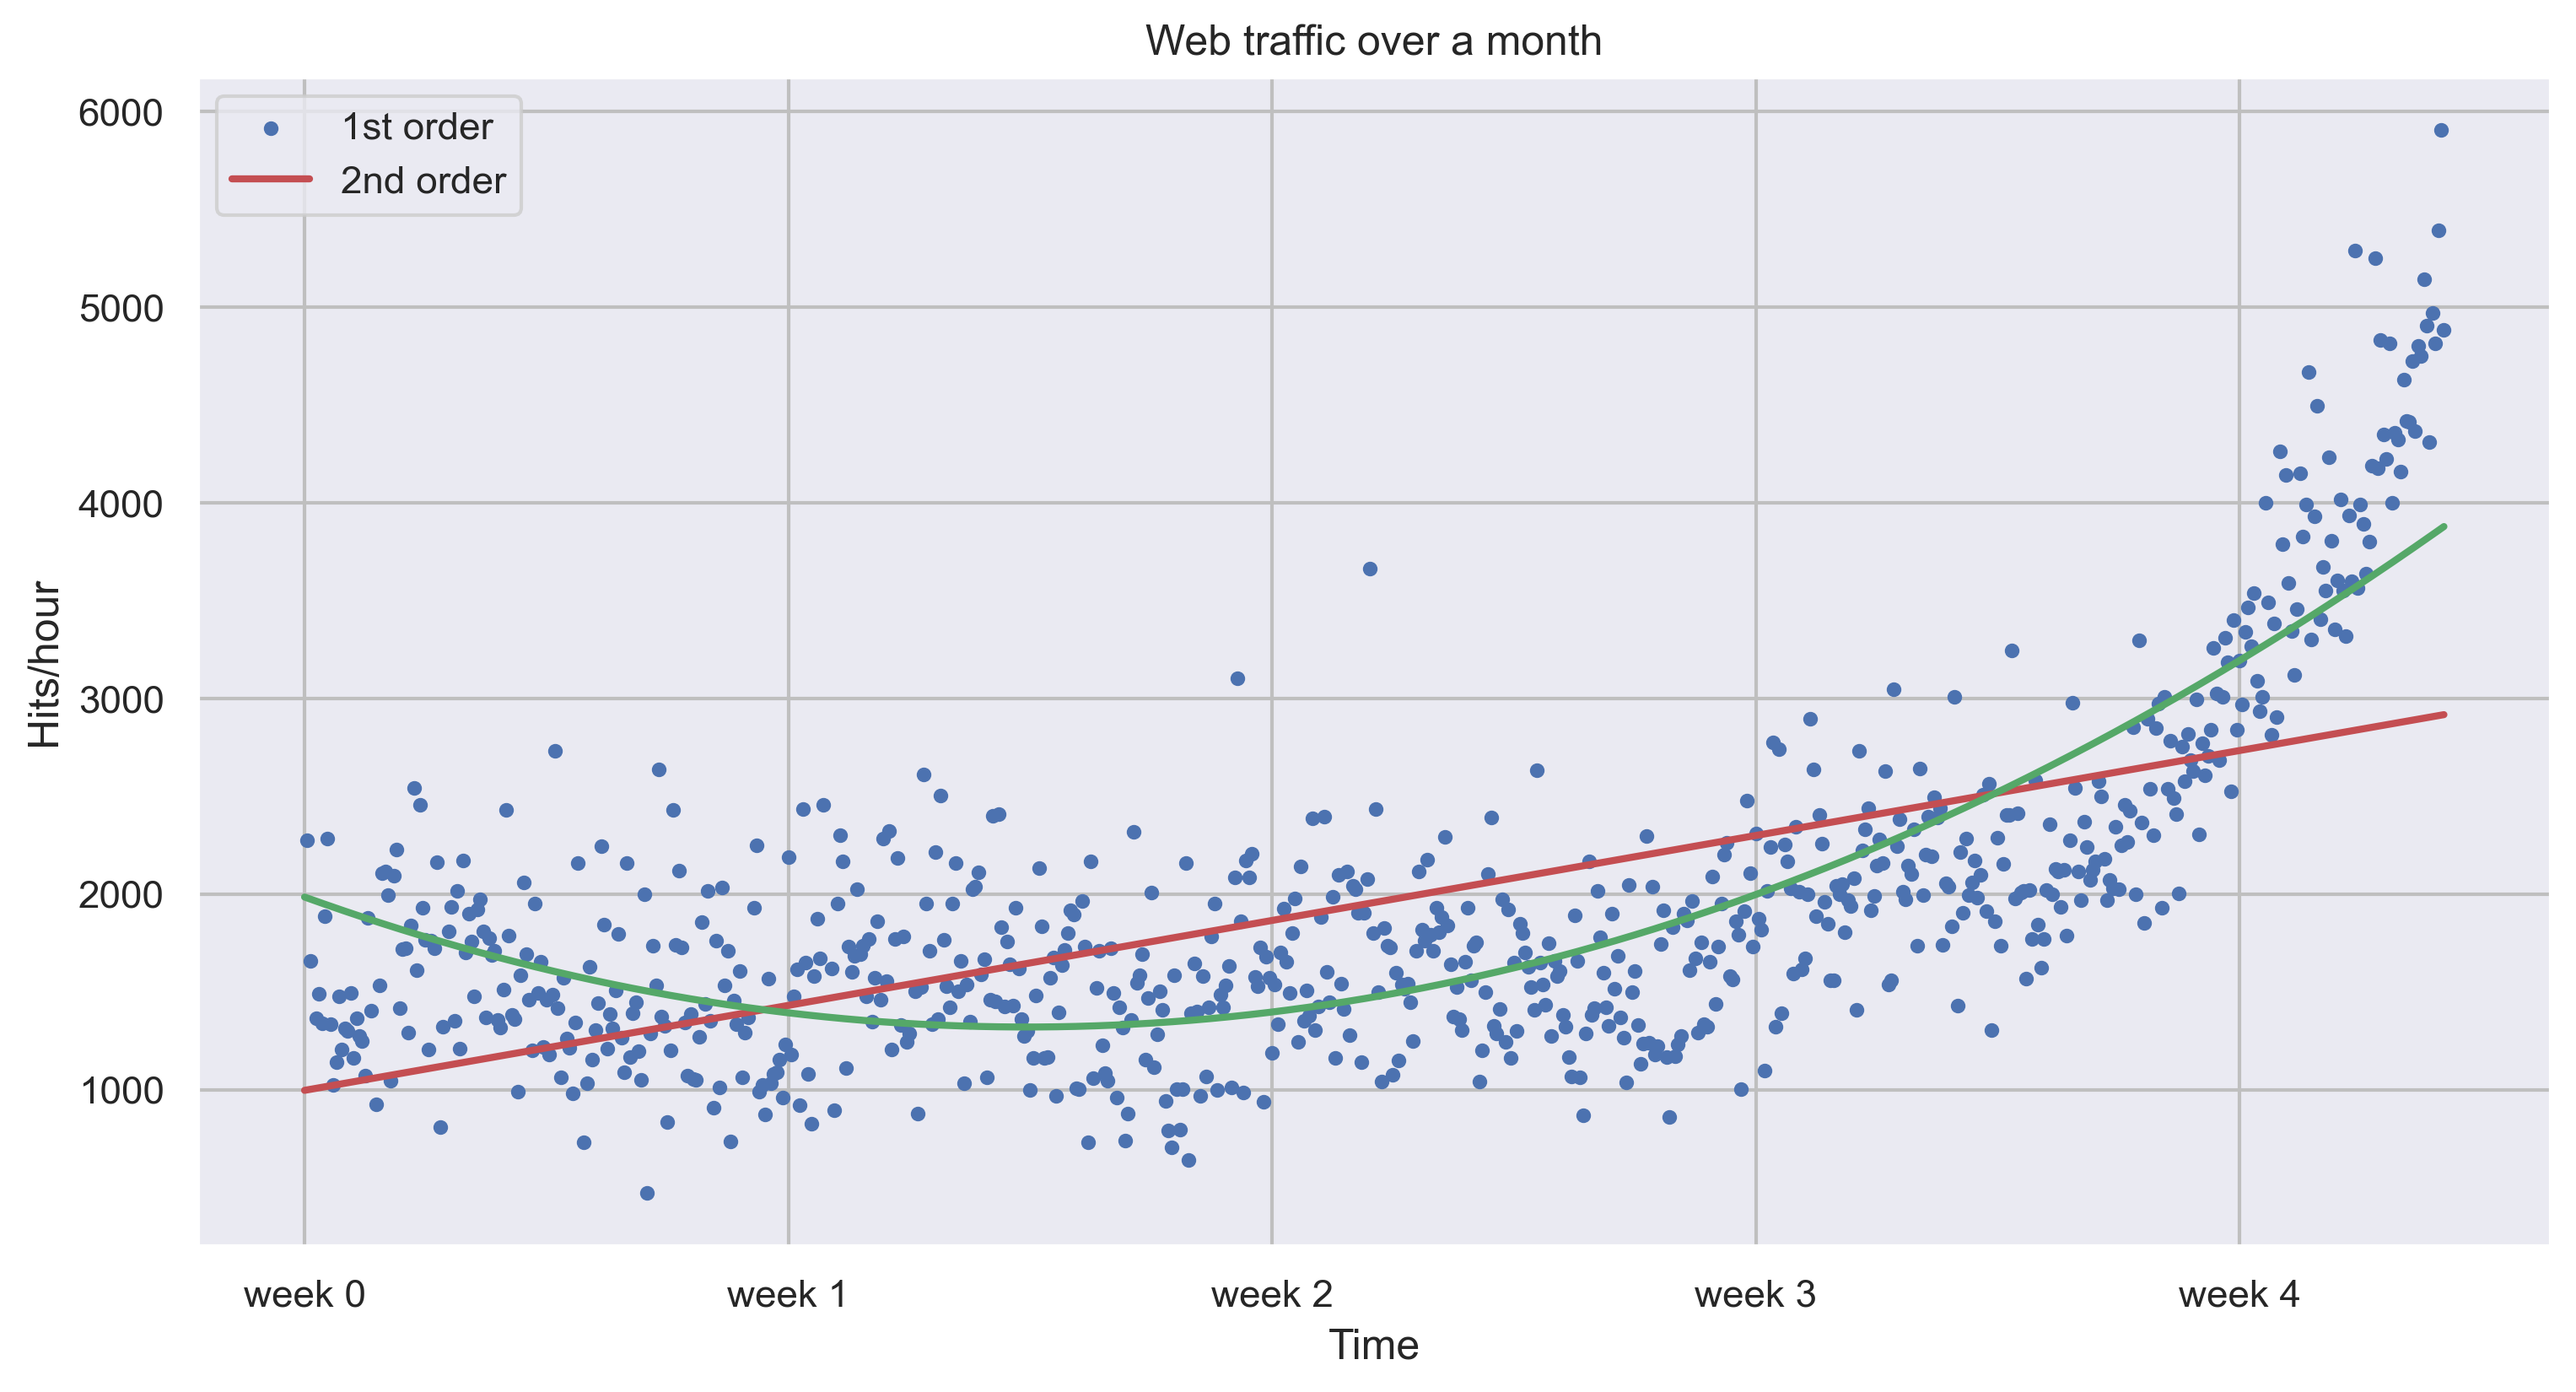

In [51]:
# Plot samples and 1st and 2nd order regression lines
fx = np.linspace(0,x.iloc[-1], 1000) # generate X-values for plotting 


plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=10)
plt.title("Web traffic over a month") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(5)],['week {}'.format(w) for w in range(5)])

# TODo: Plot 1st and 2nd order curves
plt.plot(fx, f1(fx), 'r', linewidth=2)
plt.plot(fx, f2(fx), 'g', linewidth=2)
# Legend
plt.legend(["1st order", "2nd order"], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

### 4.4 Higher order of degrees

Try it for degrees 3, 10, and 50.

In [53]:
p3, [residuals, rank, singular_values, rcond] = P.polyfit(x, y, 3, full=True)
f3 = np.poly1d(p3[::-1])
f3_residual = error(f3,x,y)

p10, [residuals, rank, singular_values, rcond] = P.polyfit(x, y, 10, full=True)
f10 = np.poly1d(p10[::-1])
f10_residual = error(f10,x,y)

p50, [residuals, rank, singular_values, rcond] = P.polyfit(x, y, 50, full=True)
f50 = np.poly1d(p50[::-1])
f50_residual = error(f50,x,y)


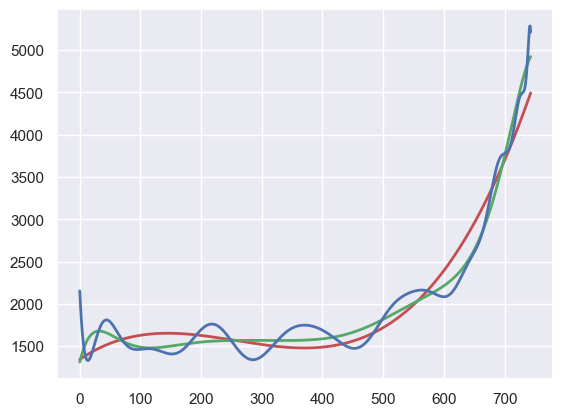

In [55]:
# TODO: print model curves of 3rd, 10th and 50th degree
plt.plot(fx, f3(fx), 'r', linewidth=2)
plt.plot(fx, f10(fx), 'g', linewidth=2)
plt.plot(fx, f50(fx), 'b', linewidth=2)

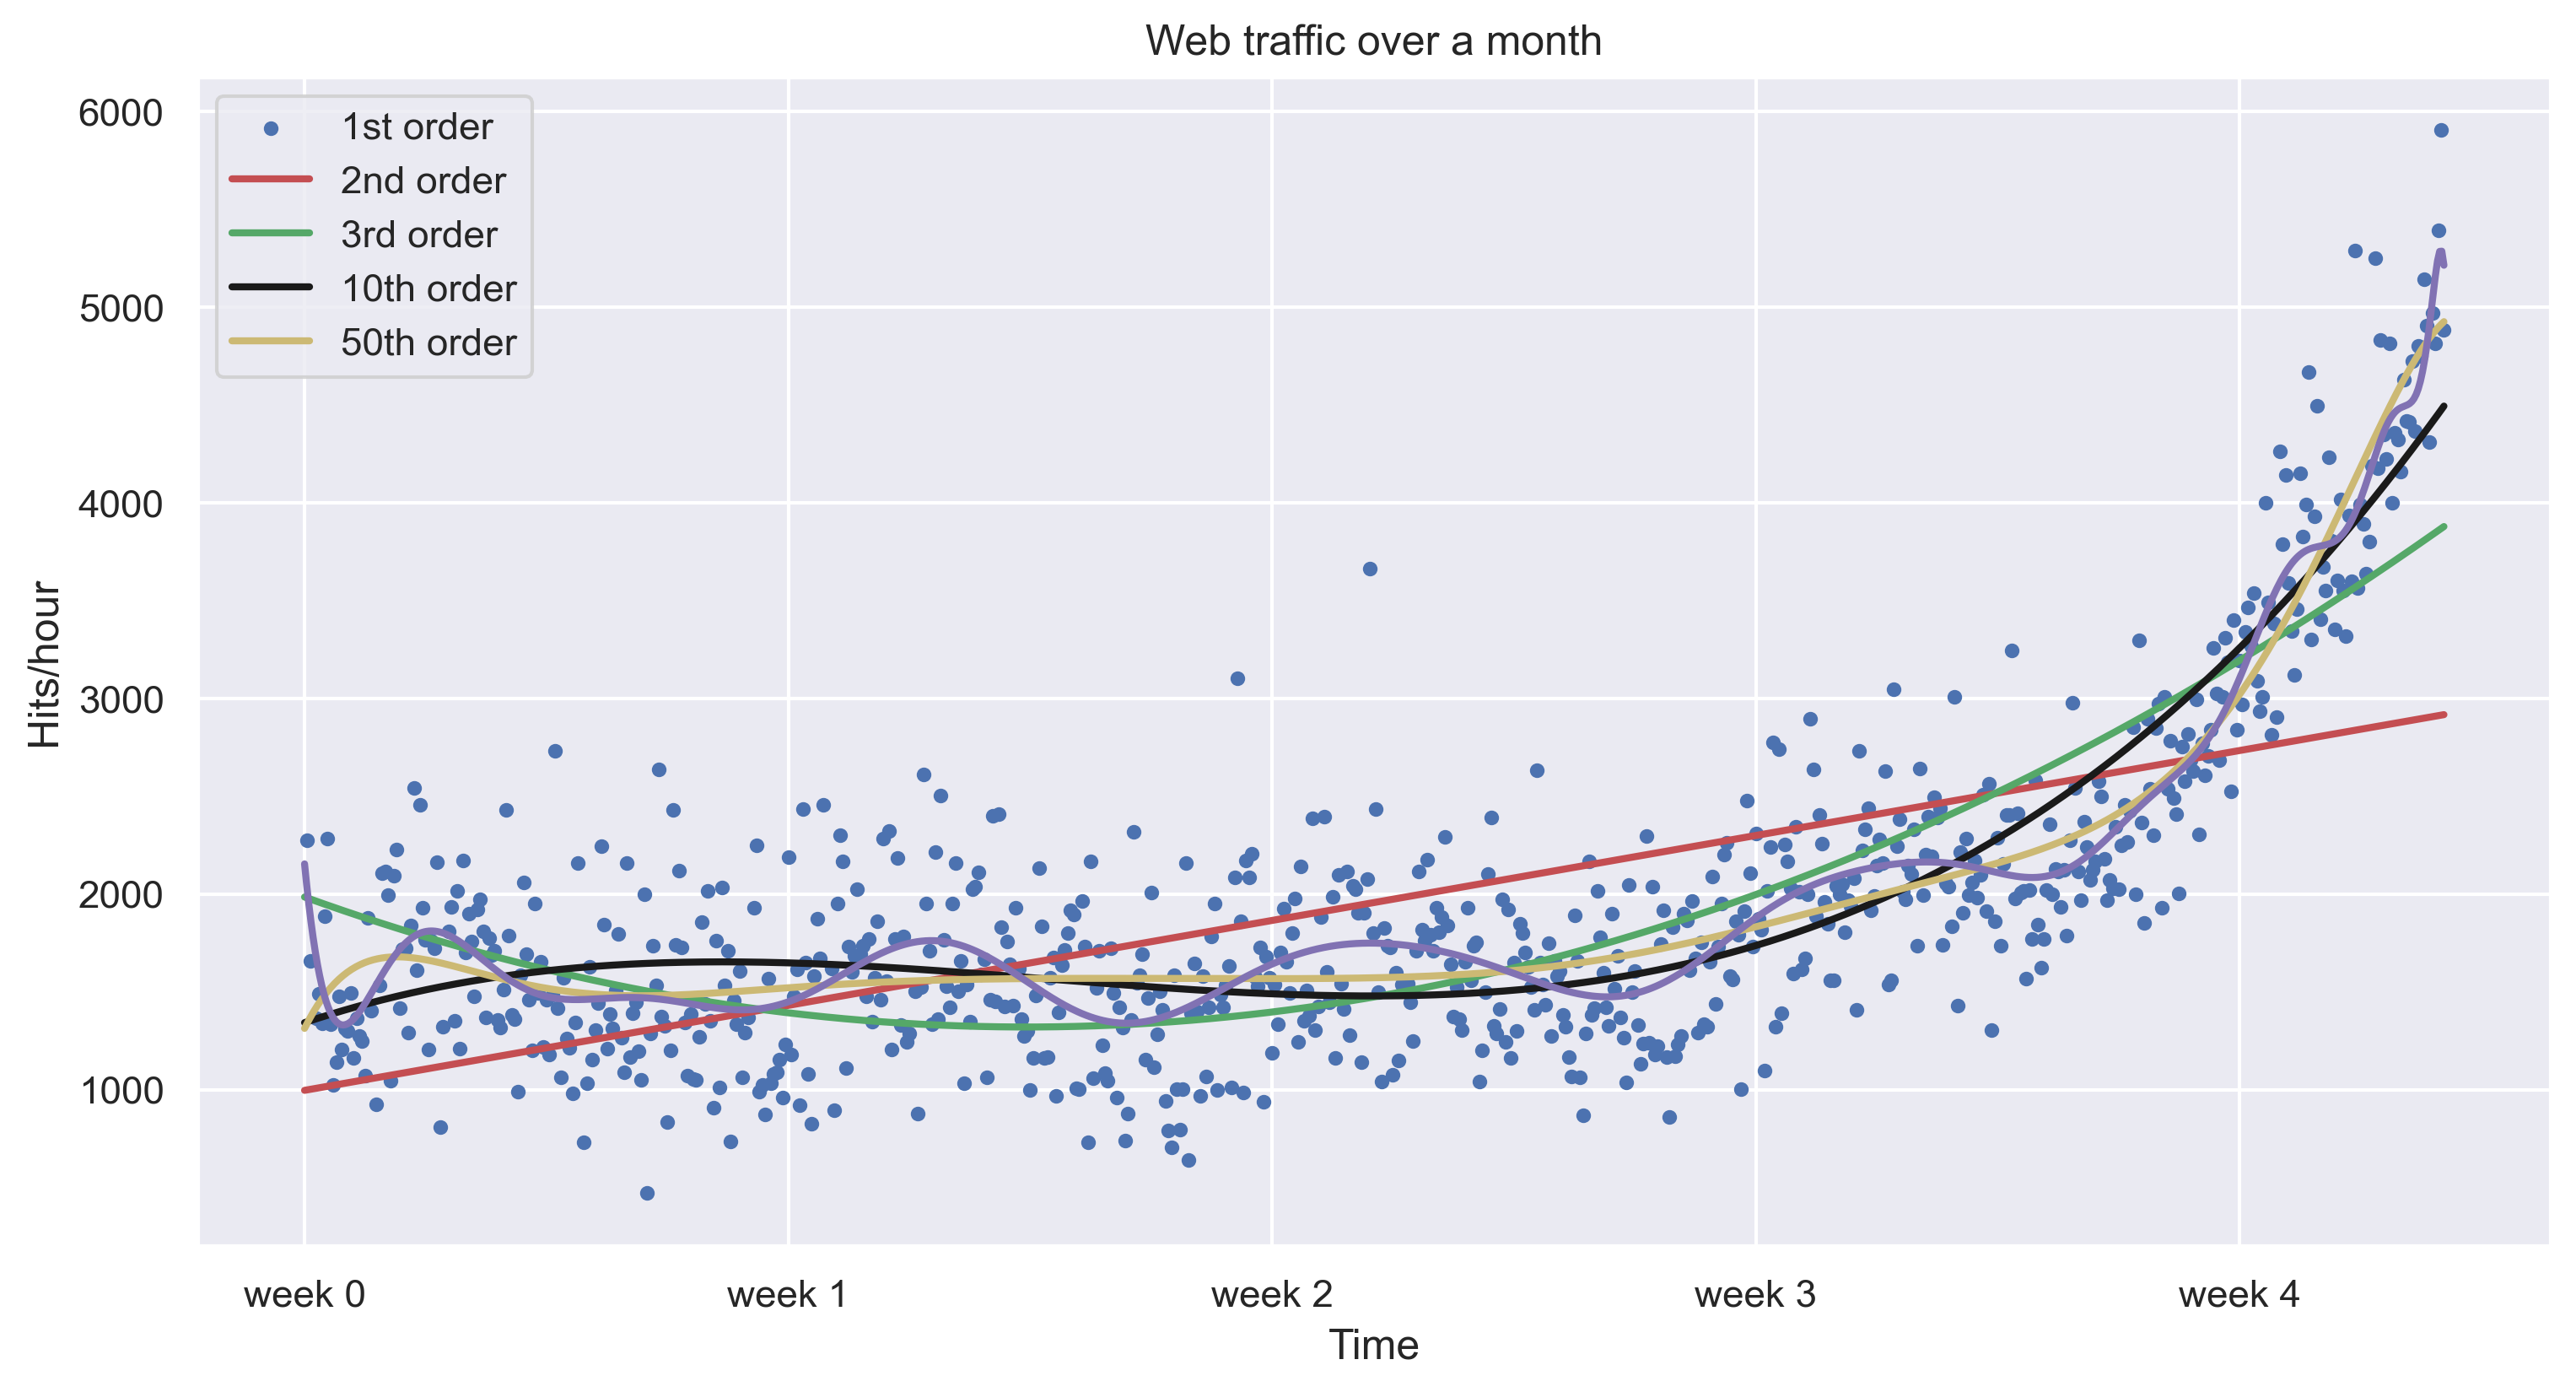

In [57]:
# Plot samples and 1st and 2nd order regression lines
fx = np.linspace(0,x.iloc[-1], 1000) # generate X-values for plotting 


plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=10)
plt.title("Web traffic over a month") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(5)],['week {}'.format(w) for w in range(5)])

# TODO: 1st, 2nd, 3rd, 10th and 50th order
plt.plot(fx, f1(fx), 'r', linewidth=2)
plt.plot(fx, f2(fx), 'g', linewidth=2)
plt.plot(fx, f3(fx), 'k', linewidth=2)
plt.plot(fx, f10(fx), 'y', linewidth=2)
plt.plot(fx, f50(fx), 'm', linewidth=2)
# Legend
plt.legend(["1st order", "2nd order", "3rd order", "10th order", "50th order"], loc="upper left")

# draw a slightly opaque, dashed grid
#plt.grid(True, linestyle='-', color='0.75')
plt.grid(True)
plt.show()

It seems like the curves capture and better the fitted data the more complex they get. Lets plot the errors.

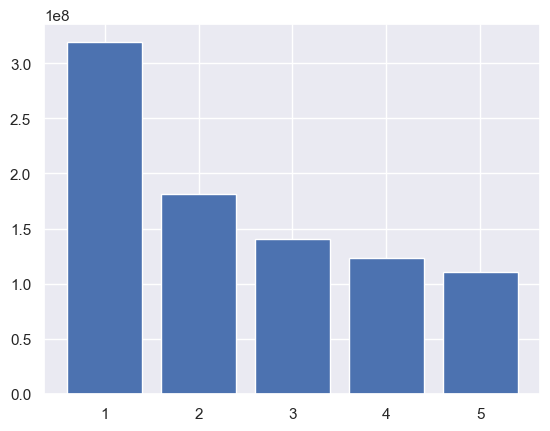

Errors: [319531507.0208318, 181347660.75761026, 140576460.87968162, 123426935.75168347, 110828361.27345961]


In [61]:
errors =[f1_residual, f2_residual, f3_residual, f10_residual, f50_residual]

# ToDo: Plot the bar diagram of erros of 1st, 2nd, 3rd, 10th and 50th degree curves
plt.bar([1,2,3,4,5], errors)
plt.show()
print(f'Errors: {errors}')

However, taking a closer look at the fitted curves, one starts to wonder whether they also capture the true process that generated that data. - Do the models correctly represent the underlying mass behavior of customers visiting on the website? 

Looking at the polynomial of degree 10 and 50, one can see wildly oscillating behavior. It seems that the models are `fitted too much` to the data. So much that it is now capturing not only the underlying process but also the noise. This is called `overfitting`.

At this point, one has the following choices:
- Choosing one of the fitted polynomial models.
- Switching to another more complex model class. Splines?
- Thinking differently about the data and start again.

Out of the five fitted models, the first order model clearly is too simple, and the models of order 10 and 50 are clearly overfitting. Only the second and third order models seem to somehow match the data. However, if we extrapolate them at both borders, we see them going berserk.

Switching to a more complex class seems also not to be the right way to go. What arguments would back which class? At this point, we realize that we probably have not fully understood our data.

### 4.5 Stepping back to go forward – another look at our data

So, we step back and take another look at the data. It seems that there is an inflection point between weeks 3 and 4. So let's separate the data and train two lines using week 3.5 as a separation point:

In [63]:
# calculate the inflection point in hours 
inflection = int(3.5*7*24)

# ToDo: split the dataset into two parts using inflection: name the vars [xa, ya] and [xb, yb]
xa = x[:inflection]
ya = y[:inflection]

xb = x[inflection:]
yb = y[inflection:]

fa = np.poly1d(P.polyfit(xa, ya, 1)[::-1]) 
fb = np.poly1d(P.polyfit(xb, yb, 1)[::-1])

fa_error = error(fa, xa, ya)
fb_error = error(fb, xb, yb)
print("Error inflection={}".format(fa_error + fb_error)) 


Error inflection=134390576.31295496


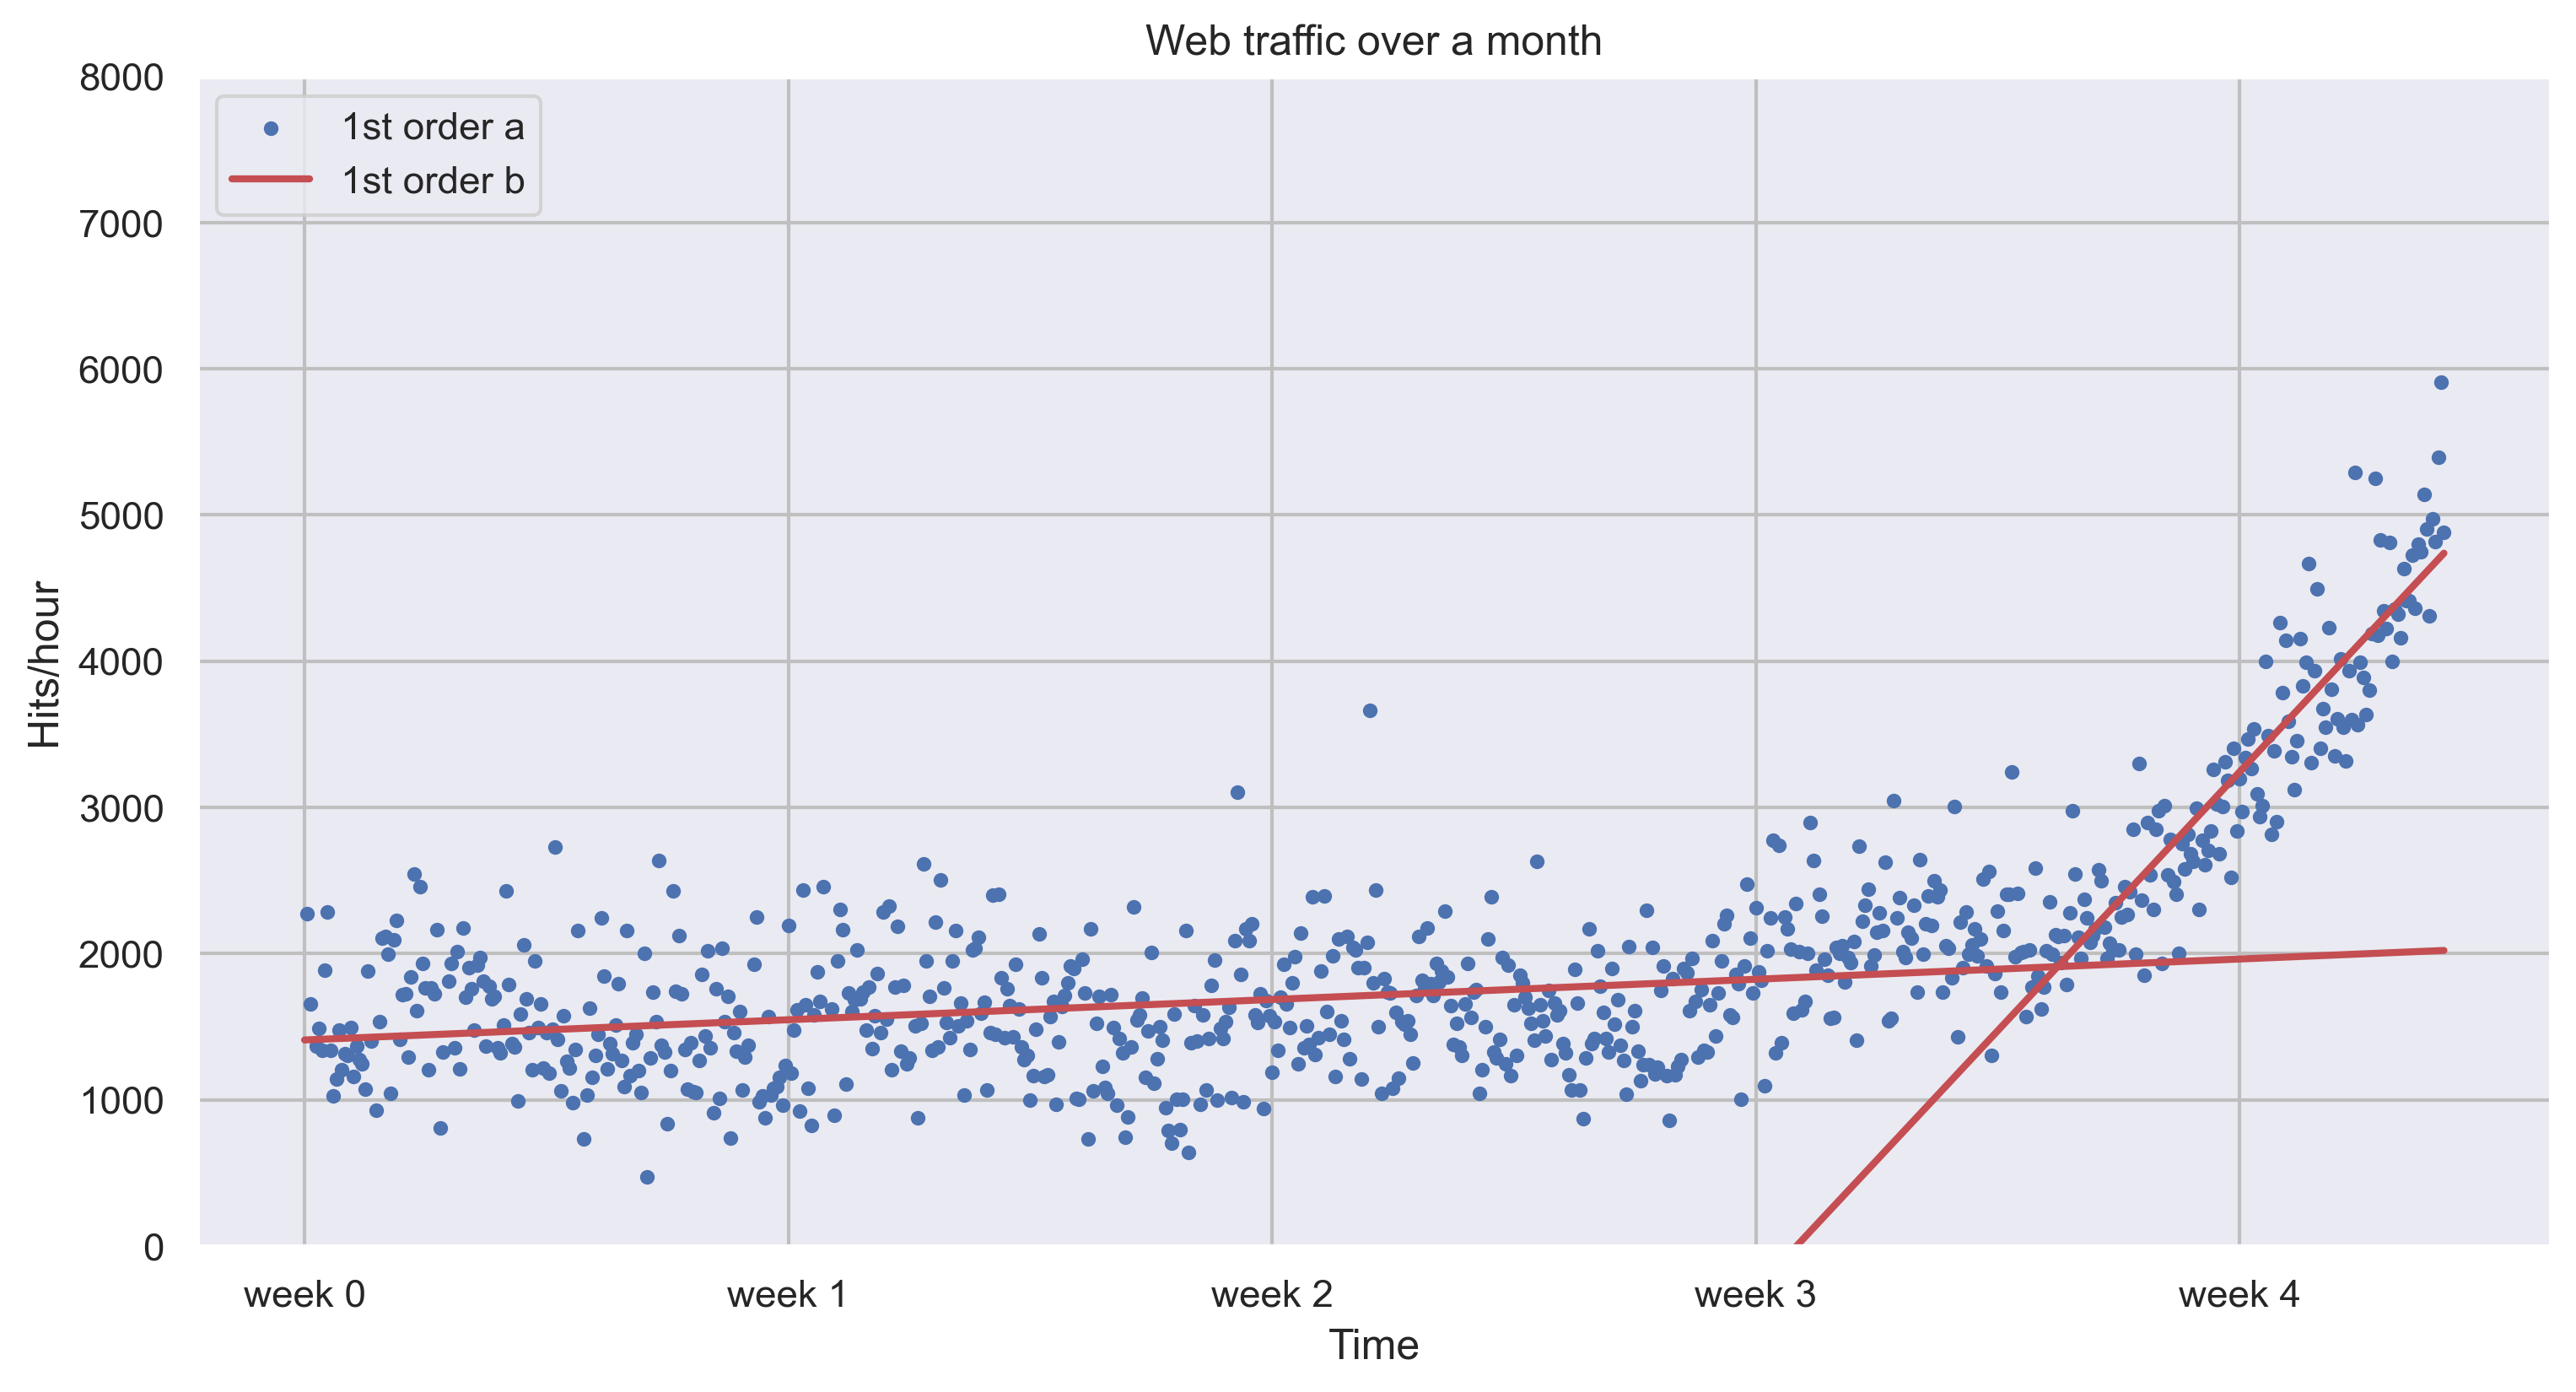

In [73]:
# Plot samples and 1st and 2nd order regression lines
fx = np.linspace(0,x.iloc[-1], 1000) # generate X-values for plotting 

plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=10)
plt.title("Web traffic over a month") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(5)],['week {}'.format(w) for w in range(5)])

# limit the plotting area
ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([0, 8000])


# ToDo: Plot the 1st order regression line a
plt.plot(fx, fa(fx), 'r', linewidth=2)

# ToDo: Plot the 1st order regression line b
plt.plot(fx, fb(fx), 'r', linewidth=2)

# Legend
plt.legend(["1st order a","1st order b"], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

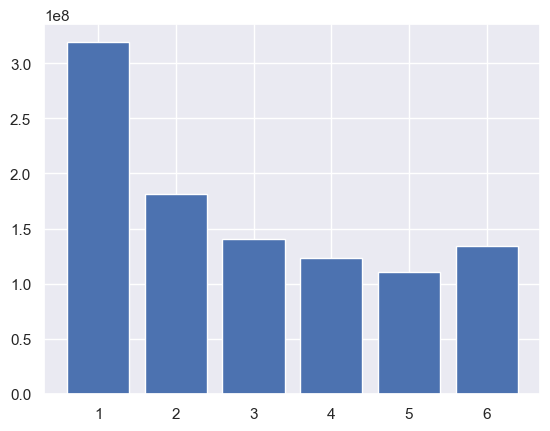

[319531507.0208318, 181347660.75761026, 140576460.87968162, 123426935.75168347, 110828361.27345961, 134390576.31295496]


In [67]:
errors =[f1_residual, f2_residual, f3_residual, f10_residual, f50_residual, fa_error + fb_error]
plt.bar([1,2,3,4,5,6], errors)
plt.show()
print(errors)

Clearly, the combination of these two lines seems to be a much better fit to the data than anything we have modeled before. But still, the combined error is higher than the higher order polynomials. Can we trust the error at the end?

Asked differently, `why do we trust` the straight line fitted only at the last week of our data more than any of the more complex models? It is because we assume that it `will capture future data better`. If we plot the models into the future, we see how right we are (d=1 is again our initial straight line).

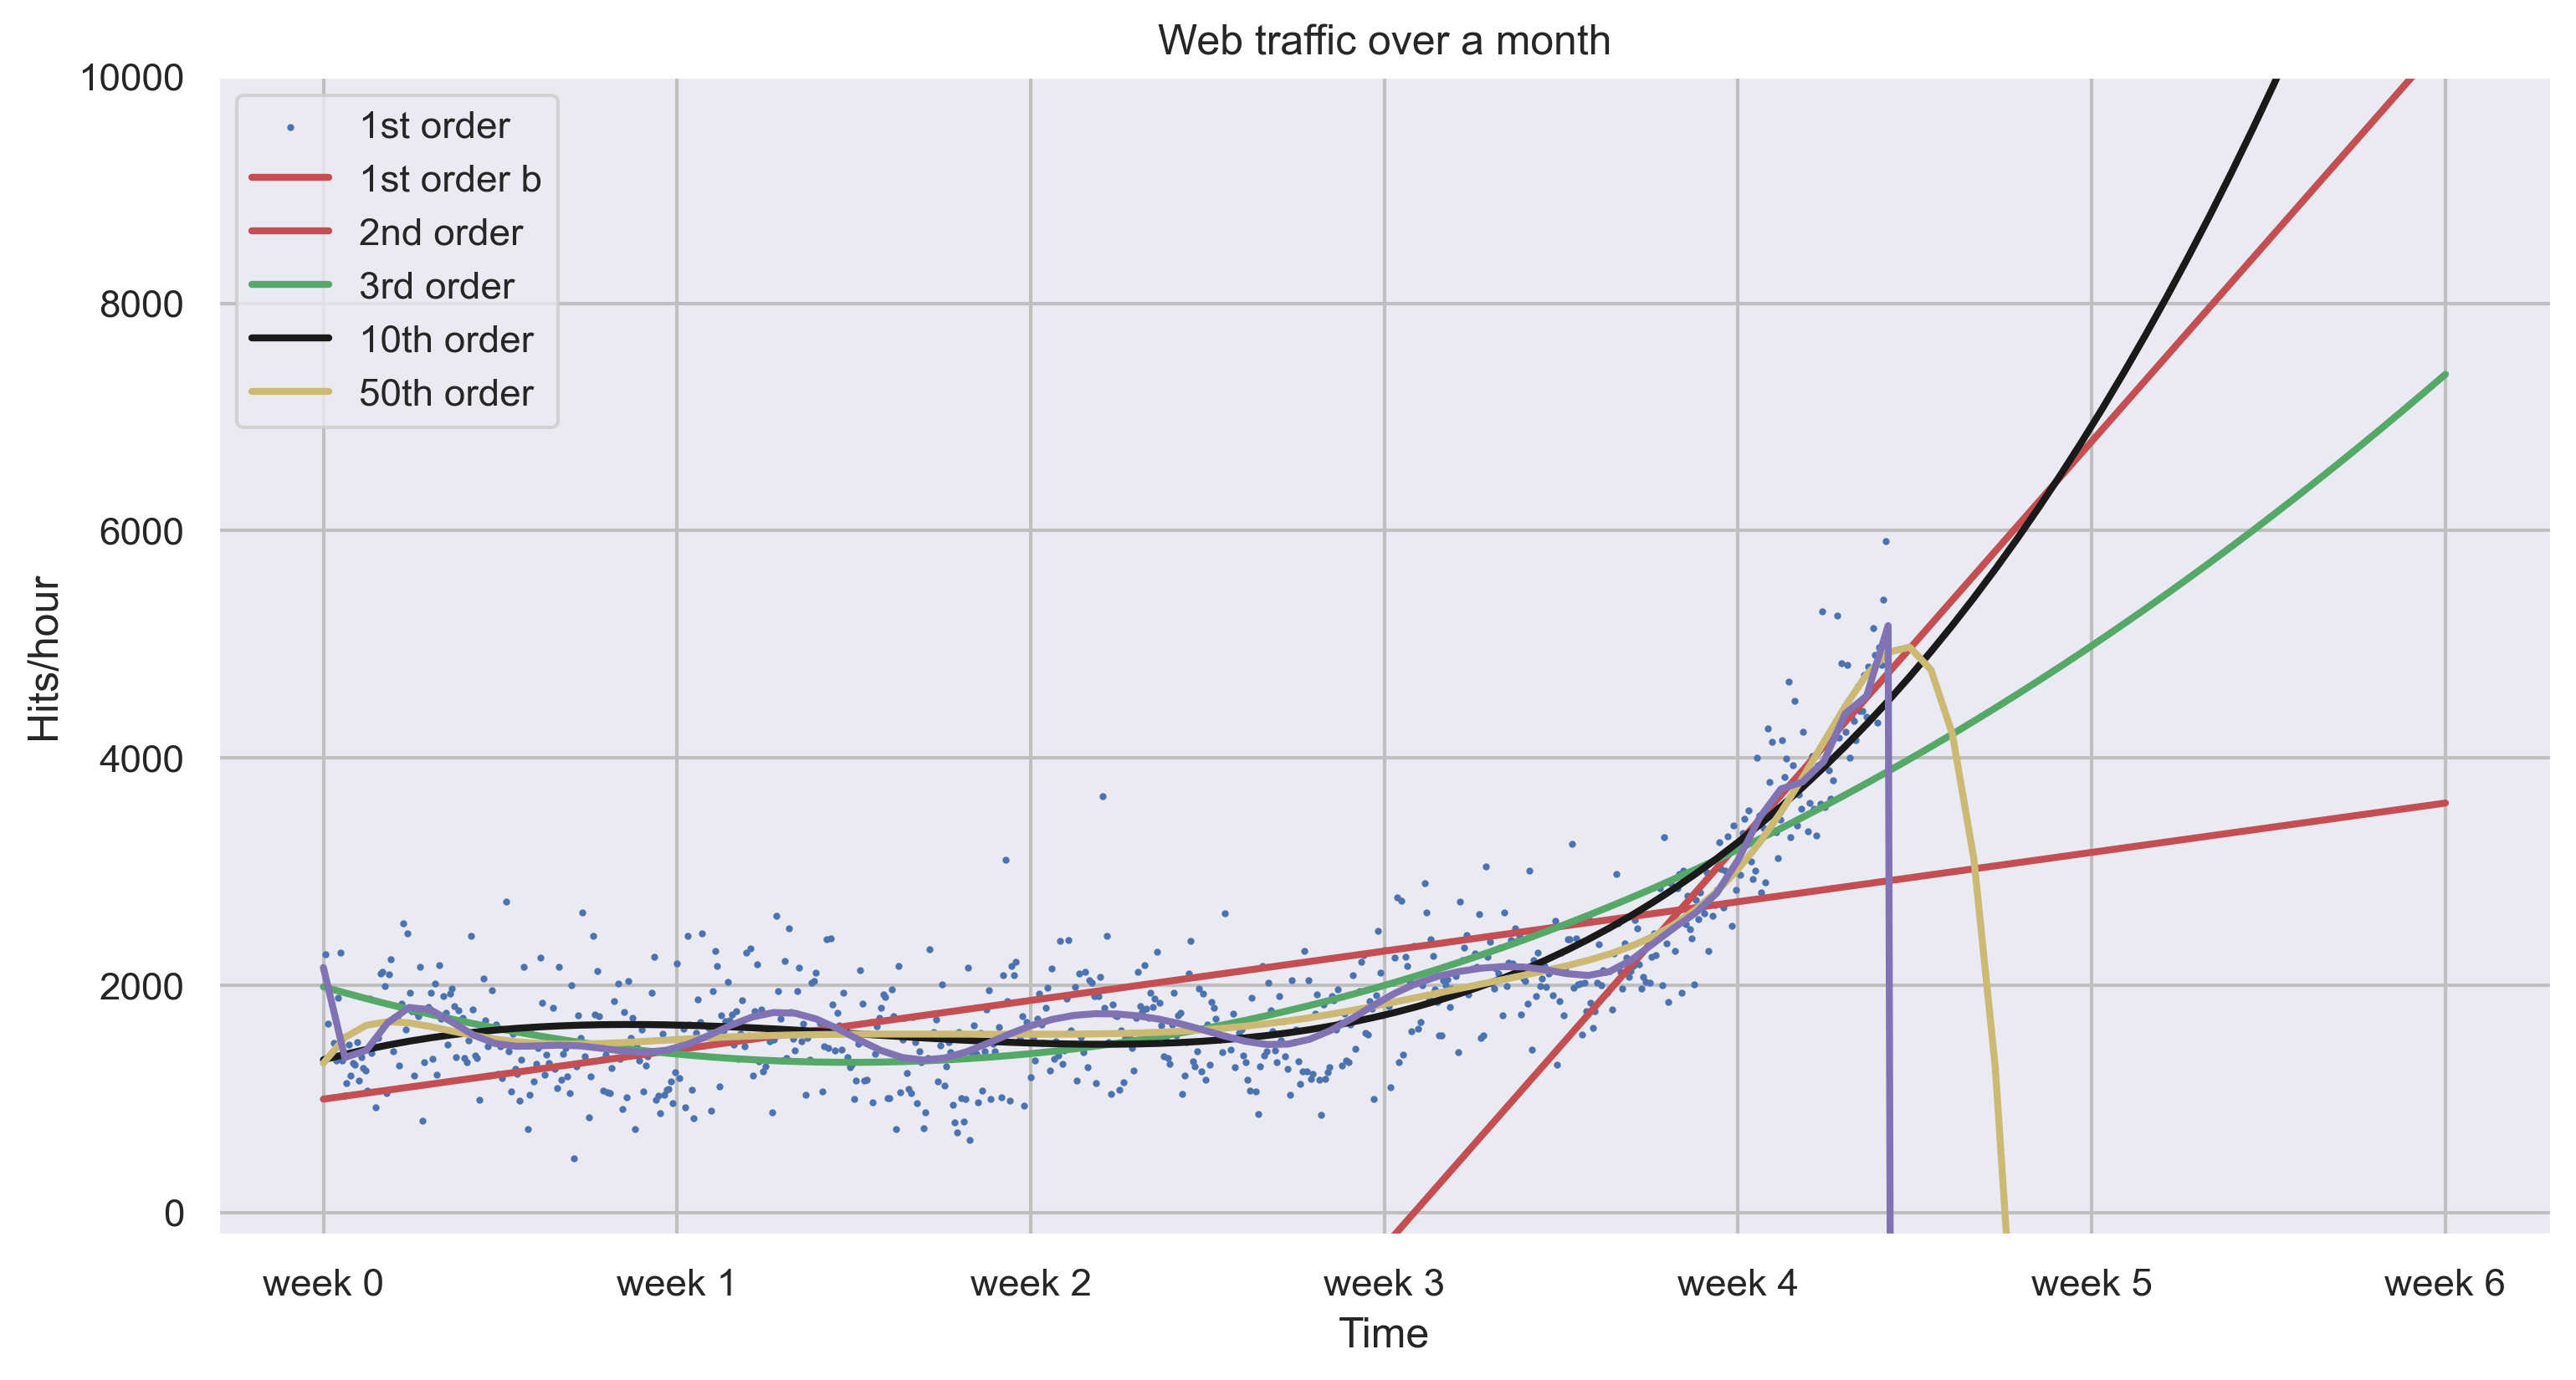

In [69]:
# Plot samples and estimates a bit longer so that we are able to estimate a bit longer (=2 weeks)
# ToDo: Generate x-axel values for plotting: 7 weeks (100 items), use fx as the variable name
fx = np.linspace(0,6*7*24, 100)

plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=1)
plt.title("Web traffic over a month") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(7)],['week {}'.format(w) for w in range(7)])

# limit the plotting area
ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([-200, 10000])

# 1st order a
plt.plot(fx, f1(fx), 'r', linewidth=2)

# 1st order b
plt.plot(fx, fb(fx), 'r', linewidth=2)

# 2nd order
plt.plot(fx, f2(fx), 'g', linewidth=2)

# 3rd order
plt.plot(fx, f3(fx), 'k', linewidth=2)

# 10th order
plt.plot(fx, f10(fx), 'y', linewidth=2)

# 50th order
plt.plot(fx, f50(fx), 'm', linewidth=2)

# Legend
plt.legend(["1st order", "1st order b", "2nd order", "3rd order", "10th order", "50th order"], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

The models of degree 10 and 50 don't seem to expect a bright future of our start-up. They tried so hard to model the given data correctly that they are clearly useless to extrapolate beyond. This is called overfitting. On the other hand, the lower degree models seem not to be capable of capturing the data good enough. This is called `underfitting`.

## 5.0 Shorten the training period

So let's play fair to models of degree 2 and above and try out how they behave if we fit them only to the data of the last week. After all, we believe that the last week says more about the future than the data prior to it. The result can be seen in the following psychedelic chart, which further shows how badly the problem of overfitting is.

In [75]:
# training perioid - last week
one_week = 7*24
x_train = x[-one_week:]
y_train = y[-one_week:]

In [77]:
# training perioid - inflection point onwards replaces previous one week 
x_train = xb
y_train = yb

In [79]:
pb1, [residuals, rank, singular_values, rcond] = P.polyfit(x_train, y_train, 1, full=True)
fb1 = np.poly1d(pb1[::-1])
fb1_residual = error(fb1,x,y)
fb1_residual_infection = error(fb1,xb,yb)

pb2, [residuals, rank, singular_values, rcond] = P.polyfit(x_train, y_train, 2, full=True)
fb2 = np.poly1d(pb2[::-1])
fb2_residual = error(fb2,x,y)
fb2_residual_infection = error(fb2,xb,yb)

pb3, [residuals, rank, singular_values, rcond] = P.polyfit(x_train, y_train, 3, full=True)
fb3 = np.poly1d(pb3[::-1])
fb3_residual = error(fb3,x,y)
fb3_residual_infection = error(fb3,xb,yb)

pb10, [residuals, rank, singular_values, rcond] = P.polyfit(x_train, y_train, 10, full=True)
fb10 = np.poly1d(pb10[::-1])
fb10_residual = error(fb10,x,y)
fb10_residual_infection = error(fb10,xb,yb)

pb50, [residuals, rank, singular_values, rcond] = P.polyfit(x_train, y_train, 50, full=True)
fb50 = np.poly1d(pb50[::-1])
fb50_residual = error(fb50,x,y)
fb50_residual_infection = error(fb50,xb,yb)


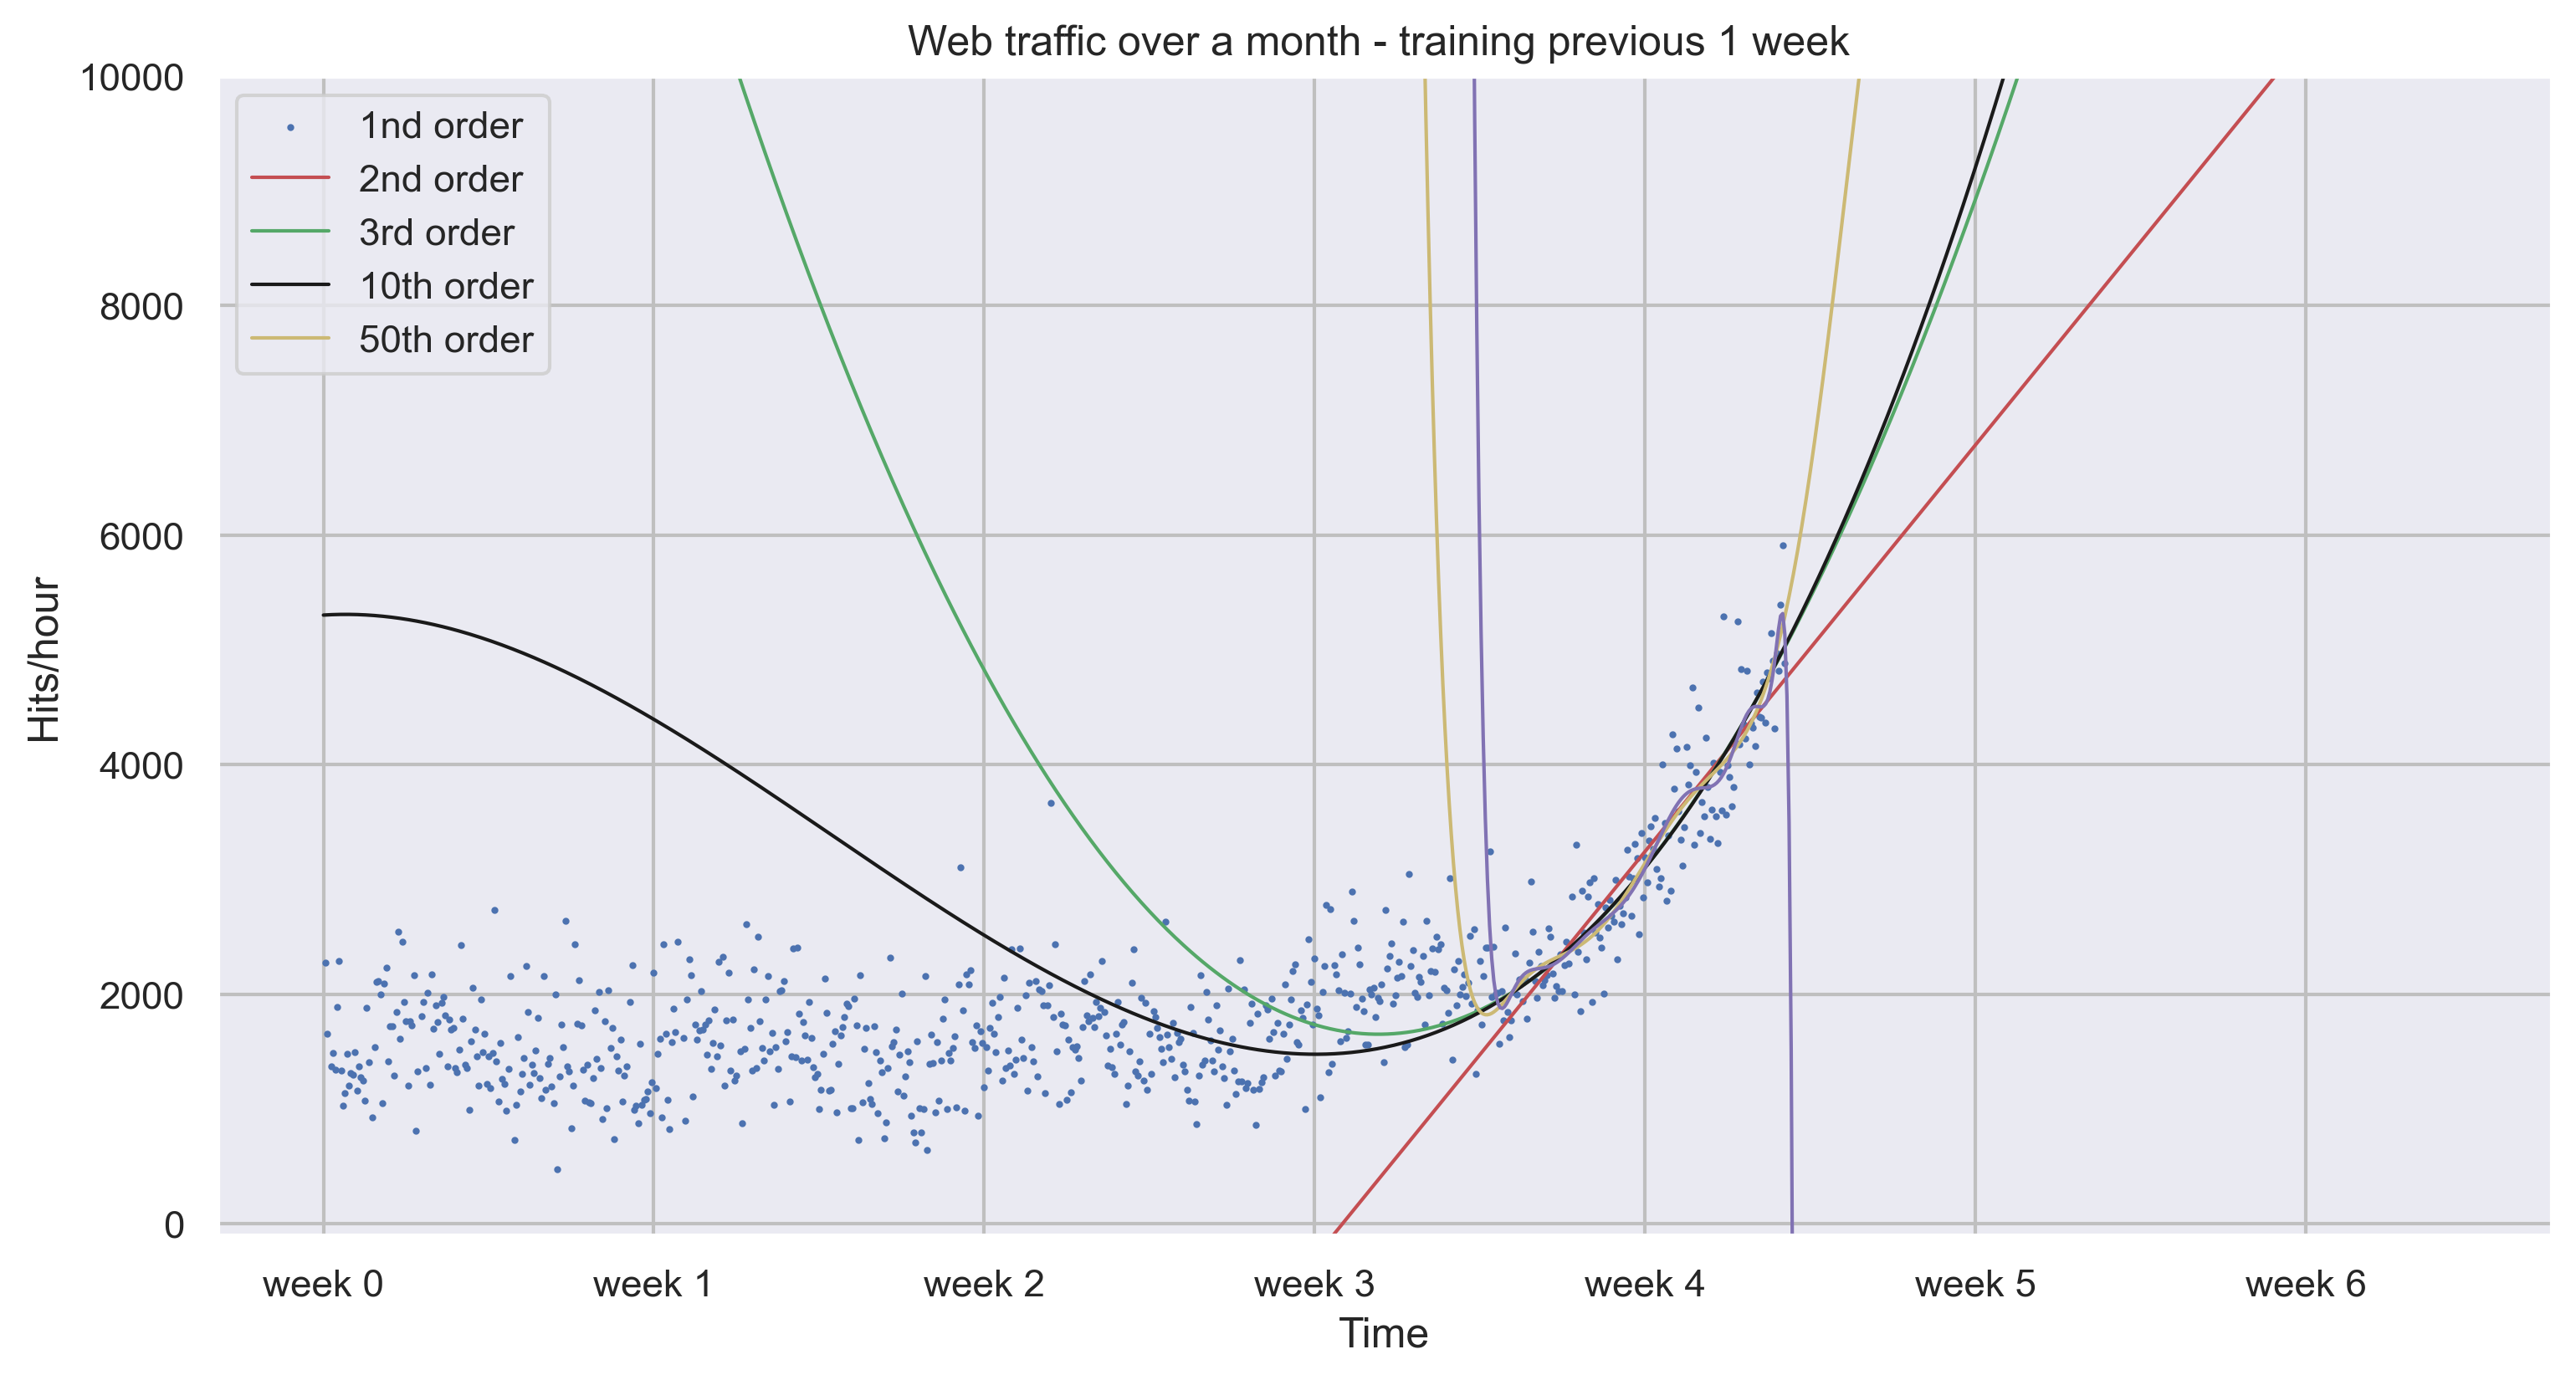

In [81]:
# Plot samples 1nd order and above regression lines
fx = np.linspace(0,x.iloc[-1]+(2*7*24), 1000) # generate X-values for plotting 

plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=1)
plt.title("Web traffic over a month - training previous 1 week ") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(7)],['week {}'.format(w) for w in range(7)])

ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([-100, 10000])

# 1st order
plt.plot(fx, fb1(fx), 'r', linewidth=1)

# 2nd order
plt.plot(fx, fb2(fx), 'g', linewidth=1)

# 3rd order
plt.plot(fx, fb3(fx), 'k', linewidth=1)

# 10th order
plt.plot(fx, fb10(fx), 'y', linewidth=1)

# 50th order
plt.plot(fx, fb50(fx), 'm', linewidth=1)

# Legend
plt.legend(["1nd order", "2nd order", "3rd order", "10th order", "50th order"], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

In [83]:
# Total errors 
errors =[fb1_residual, fb2_residual, fb3_residual, fb10_residual, fb50_residual]
print(errors)

[30105401800.343735, 54088333585.56832, 2760739769.381984, 3.6723220465715637e+21, 1.7272690872638227e+25]


In [85]:
# Errors only after the infection point
errors =[fb1_residual_infection, fb2_residual_infection, fb3_residual_infection, fb10_residual_infection, fb50_residual_infection]
print(errors)

[22140590.599277064, 19764355.660565764, 19762196.40468432, 18942545.481087957, 18330070.83322326]


## 6. Splitting training and testing

Let's use 30% of the web traffic data after the inflection point as test data that we do not train on.

In [87]:
frac = 0.3
split_idx = int(frac * len(xb))
shuffled = np.random.permutation(list(range(len(xb))))

test = sorted(shuffled[:split_idx])
train = sorted(shuffled[split_idx:])


In [89]:
print("Random indexes:\n{}".format(shuffled))
print("Test set indexes:\n{}".format(shuffled[:split_idx]))
print("Train set indexes:\n{}".format(shuffled[split_idx:]))
print("Test values:\n{}".format(test))

Random indexes:
[ 14 101  12  77 123  24 112 110  21  58 131 121 137 125  95  53  54   8
  51 119  85  44 116  11 141 146 113 144 111  62  65  67  34  69 133  40
  37  23  71  63  31  10 145   0  52  81  91  80  86  35  76  98  16 105
   3 129   1 128  38  60   9  30  83  73  39   4  64  78  66  18  22 118
 142  96 103  79 107  13  32 134  29 124  27  97 126  70  56 140  59  55
  84  74 138  82  17 130  33   5 122 100  93  41  50  88  20  46  36  49
   6  99 139 114  47 117  61 115 106  25  28 135  26 120  48 102  89  92
  90 132 104  42 109  15  43 108   7  68  45 127  72 143  19  75  87   2
  57 136  94]
Test set indexes:
[ 14 101  12  77 123  24 112 110  21  58 131 121 137 125  95  53  54   8
  51 119  85  44 116  11 141 146 113 144 111  62  65  67  34  69 133  40
  37  23  71  63  31  10 145   0]
Train set indexes:
[ 52  81  91  80  86  35  76  98  16 105   3 129   1 128  38  60   9  30
  83  73  39   4  64  78  66  18  22 118 142  96 103  79 107  13  32 134
  29 124  27  97 126  7

In [91]:
fbt1 = np.poly1d(P.polyfit(xb.iloc[train], yb.iloc[train], 1)[::-1])
fbt2 = np.poly1d(P.polyfit(xb.iloc[train], yb.iloc[train], 2)[::-1])

print("fbt2(x)= \n{}".format(fbt2))
print("fbt2(x)-100,000= \n{}".format(fbt2-100000))

fbt3 = np.poly1d(P.polyfit(xb.iloc[train], yb.iloc[train], 3)[::-1])
fbt10 = np.poly1d(P.polyfit(xb.iloc[train], yb.iloc[train], 10)[::-1])
fbt50 = np.poly1d(P.polyfit(xb.iloc[train], yb.iloc[train], 50)[::-1])

print("Test errors for only the time after inflection point")
for f in [fbt1, fbt2, fbt3, fbt10, fbt50]:
    print("Error d={}: {}".format(f.order, error(f, xb.iloc[test], yb.iloc[test])))


fbt2(x)= 
         2
0.07177 x - 74.63 x + 2.087e+04
fbt2(x)-100,000= 
         2
0.07177 x - 74.63 x - 7.913e+04
Test errors for only the time after inflection point
Error d=1: 5744887.564436342
Error d=2: 4756989.102720703
Error d=3: 4965504.0941964295
Error d=10: 4712276.133105385
Error d=50: 30059188.29206472


C:\Users\kroge\anaconda3\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [103]:
print("Errors for only the time after inflection point")
for f in [fb1, fb2, fb3, fb10, fb50]:
    print("\td={}: {:.10}".format(f.order, error(f, xb, yb)))

# plot_web_traffic(x, y, [fbt1, fbt2, fbt3, fbt10, fbt100],mx=np.linspace(0, 6 * 7 * 24, 100),ymax=10000,fig_idx="08")

Errors for only the time after inflection point
	d=1: 22140590.6
	d=2: 19764355.66
	d=3: 19762196.4
	d=10: 18942545.48
	d=50: 18330070.83


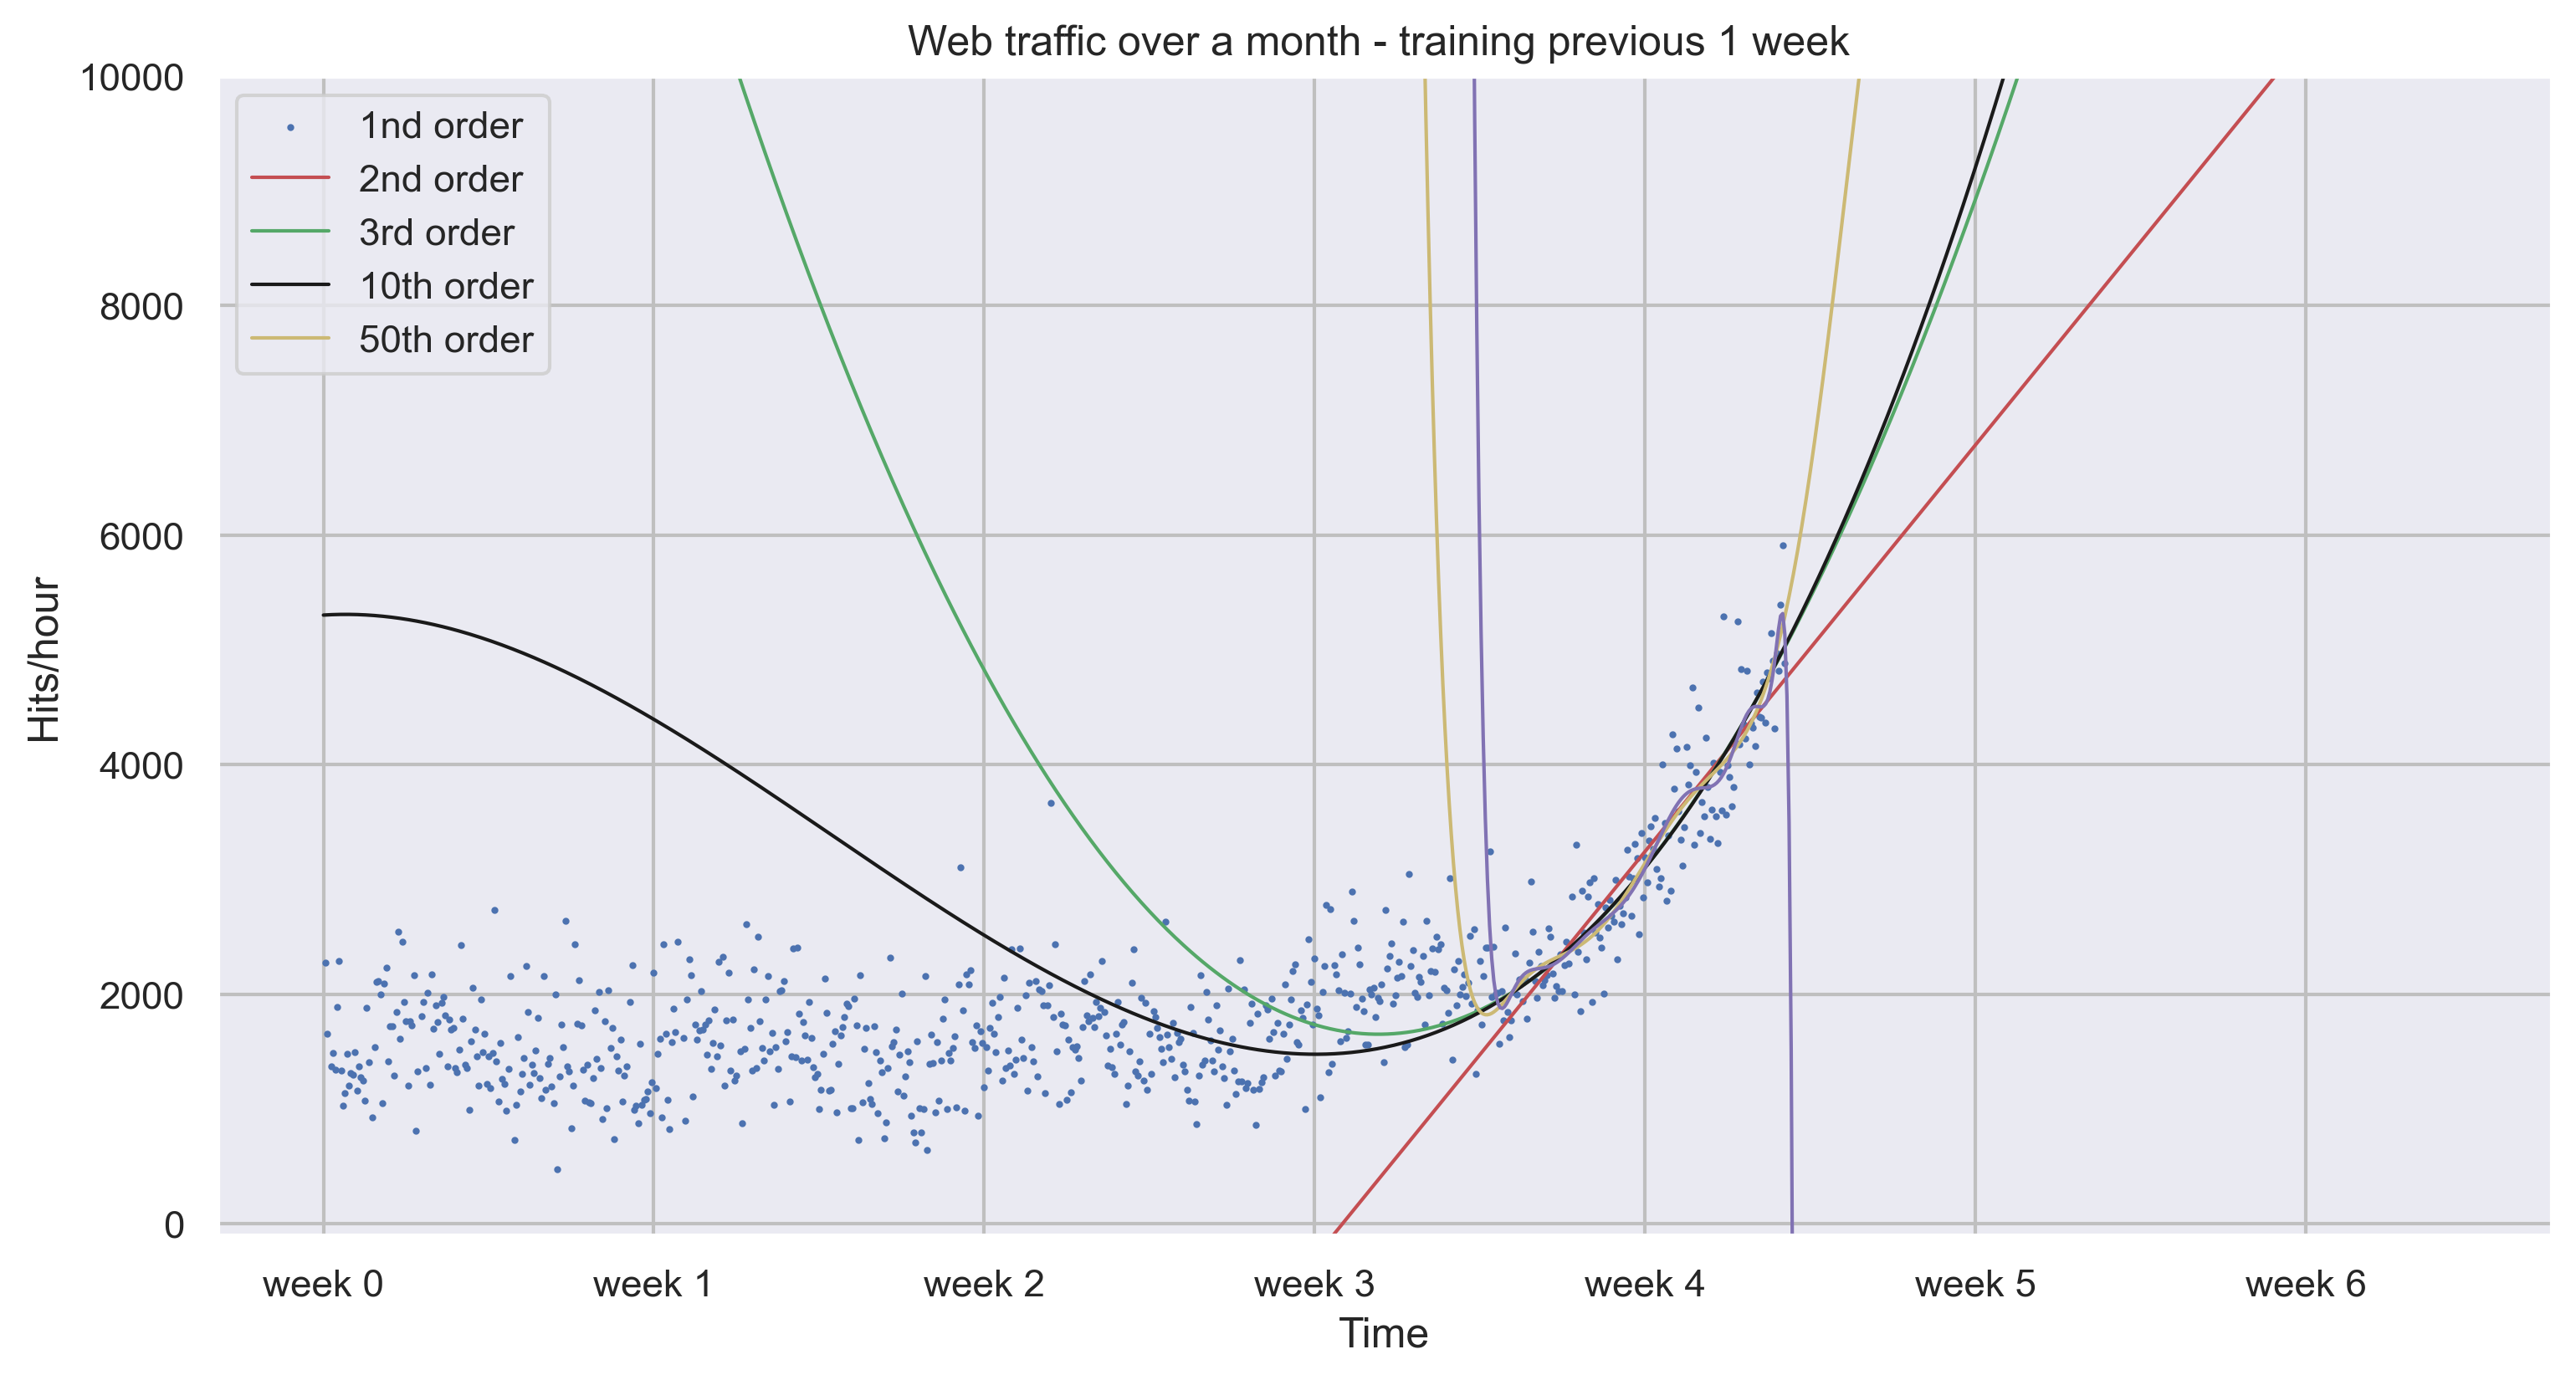

In [105]:
# Plot samples 1nd order and above regression lines
fx = np.linspace(0,x.iloc[-1]+(2*7*24), 1000) # generate X-values for plotting 

# s=markersize
plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=1)
plt.title("Web traffic over a month - training previous 1 week ") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(7)],['week {}'.format(w) for w in range(7)])

ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([-100, 10000])

# 1st order
plt.plot(fx, fb1(fx), 'r', linewidth=1)

# 2nd order
plt.plot(fx, fb2(fx), 'g', linewidth=1)

# 3rd order
plt.plot(fx, fb3(fx), 'k', linewidth=1)

# 10th order
plt.plot(fx, fb10(fx), 'y', linewidth=1)

# 50th order
plt.plot(fx, fb50(fx), 'm', linewidth=1)

# Legend
plt.legend(["1nd order", "2nd order", "3rd order", "10th order", "50th order"], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

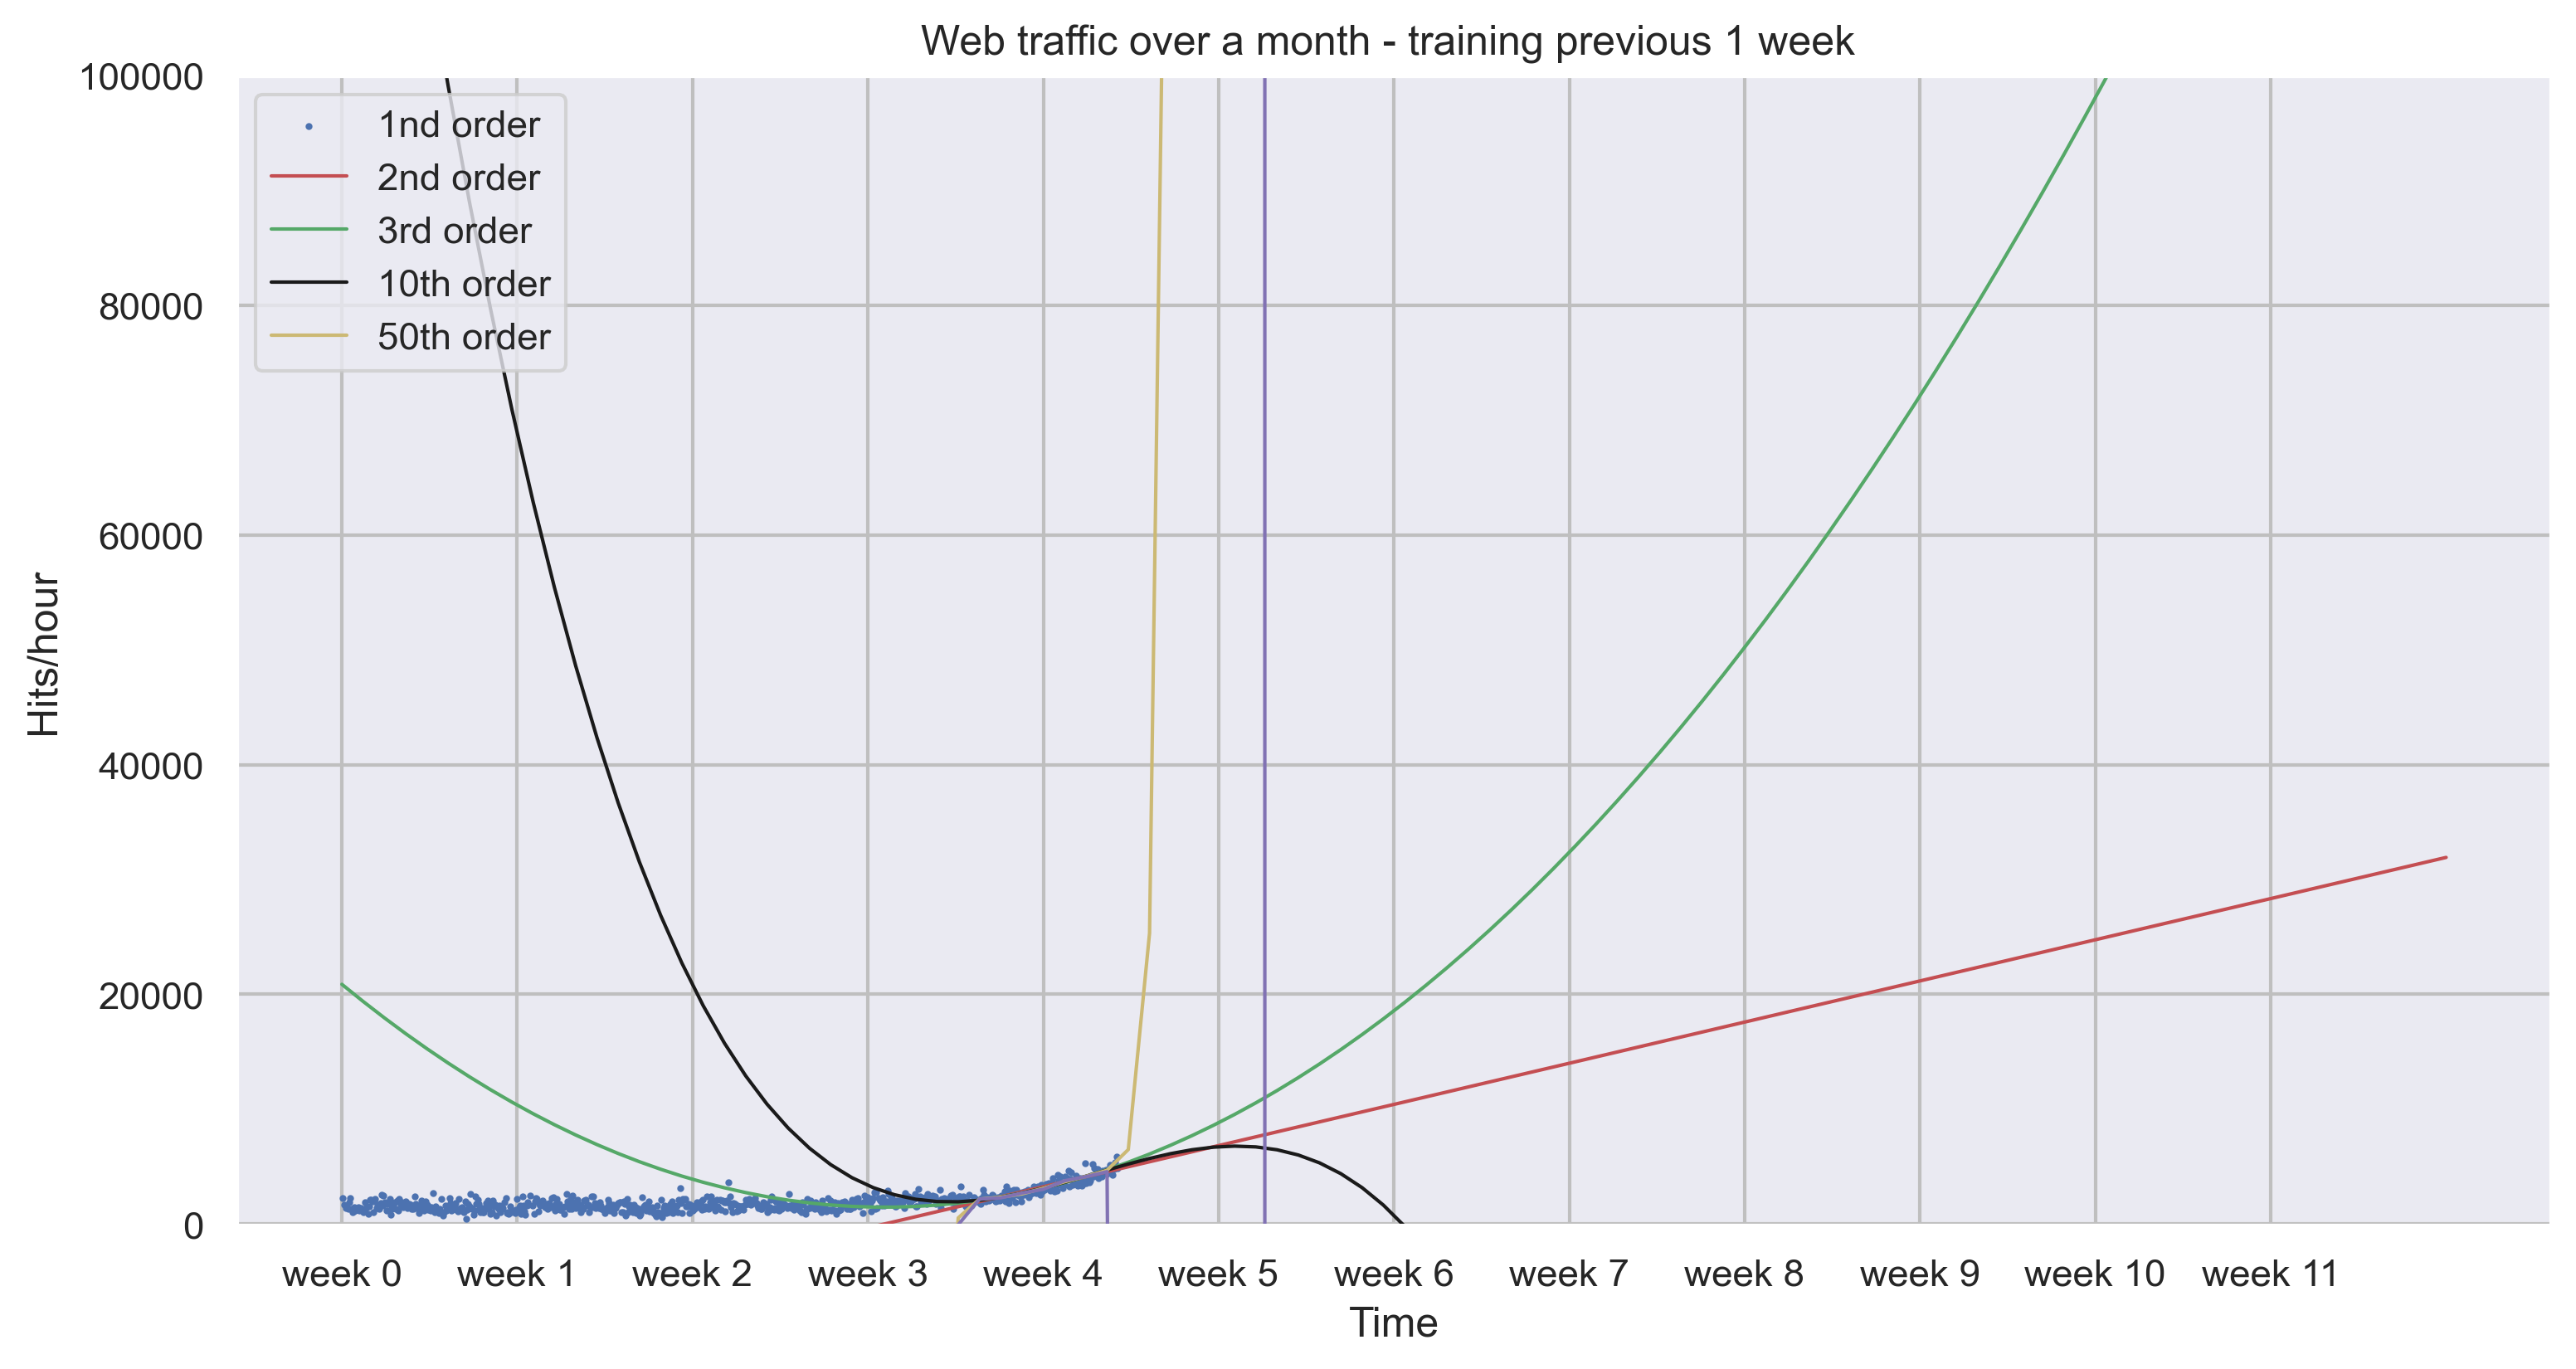

In [107]:
# TEST THIS by setting the ylim y-value (10 000 - 100 000)
##########################################################
# Plot samples 1nd order and above regression lines
# fx = np.linspace(0,x.iloc[-1]+(2*7*24), 1000) # generate X-values for plotting 
fx = np.linspace(0, 12 * 7 * 24, 100)

# s=markersize
plt.figure(figsize=(12, 6), dpi=300)
plt.scatter(x, y, s=1)
plt.title("Web traffic over a month - training previous 1 week ") 
plt.xlabel("Time")
plt.ylabel("Hits/hour")

plt.xticks([w*7*24 for w in range(12)],['week {}'.format(w) for w in range(12)])

ax = plt.gca()
# ax.set_xlim([xmin, xmax])
ax.set_ylim([-100, 100000])

# 1st order
plt.plot(fx, fbt1(fx), 'r', linewidth=1)

# 2nd order
plt.plot(fx, fbt2(fx), 'g', linewidth=1)

# 3rd order
plt.plot(fx, fbt3(fx), 'k', linewidth=1)

# 10th order
plt.plot(fx, fbt10(fx), 'y', linewidth=1)

# 50th order
plt.plot(fx, fbt50(fx), 'm', linewidth=1)

# Legend
plt.legend(["1nd order", "2nd order", "3rd order", "10th order", "50th order"], loc="upper left")

# draw a slightly opaque, dashed grid
plt.grid(True, linestyle='-', color='0.75')
plt.show()

### 7. So, when will we hit 100,000 hits per hour?

Finally we have arrived at a model which we think represents the underlying process best; it is now a simple task of finding out when our infrastructure will reach 100,000 requests per hour. We have to calculate when our model function reaches the value 100,000.

Having a polynomial of degree 2, we could simply compute the inverse of the function and calculate its value at 100,000. Of course, we would like to have an approach that is applicable to any model function easily.

This can be done by subtracting 100,000 from the polynomial, which results in another polynomial, and finding its root. SciPy's optimize module has the function fsolve that achieves this, when providing an initial starting position with parameter x0. As every entry in our input data file corresponds to one hour, and we have 743 of them, we set the starting position to some value after that. Let fbt2 be the winning polynomial of degree 2.

In [109]:
fbt2 = np.poly1d(P.polyfit(xb.iloc[train], yb.iloc[train], 2)[::-1])
print("fbt2(x)= \n{}".format(fbt2))
print("fbt2(x)-100,000= \n{}".format(fbt2-100000))

# finds the root of a function (using starting estimate x0)
from scipy.optimize import fsolve
reached_max = fsolve(fbt2-100000, x0=800)/(7*24)
print("100,000 hits/hour expected at week {}".format(reached_max[0]))

fbt2(x)= 
         2
0.07177 x - 74.63 x + 2.087e+04
fbt2(x)-100,000= 
         2
0.07177 x - 74.63 x - 7.913e+04
100,000 hits/hour expected at week 10.068938235560928


TODO: define the solution to below

It is expected to have 100,000 hits/hour at week xxx  
so our model tells us that, given the current user behavior and traction of our start-up, it will take another month until we have reached our capacity threshold.

Of course, there is a certain uncertainty involved with our prediction. To get a real picture of it, one could draw in more sophisticated statistics to find out about the variance we have to expect when looking farther and farther into the future.
And then there are the user and underlying user behavior dynamics that we cannot model accurately. However, at this point, we are fine with the current predictions.